# Airbnb Cape Town Business Analysis.

---

## Overview

This project analyzes Airbnb listings and reviews in Cape Town to uncover key drivers of revenue, guest satisfaction, and booking behavior. Using a blend of structured data modeling and NLP techniques, we built a price prediction model, extracted review topics using BERTopic, and performed sentiment analysis to surface actionable insights for hosts and Airbnb itself.

---

## Business Problem

Airbnb hosts in Cape Town face increasing competition and lack tools to optimize their listings effectively. They often rely on intuition rather than data to determine pricing, interpret reviews, and improve guest satisfaction. 

To address this, we asked:

- What factors most strongly predict listing price, listing revenue and occupancy?
- What are guests saying in reviews, and what themes consistently appear?
- How do these themes correlate with positive or negative sentiment?
- Can this insight help hosts improve their listings and Airbnb refine its search ranking?

Understanding these questions helps Airbnb and hosts alike boost guest satisfaction and optimize revenue potential.

---

## Data Understanding

We used multiple datasets from Inside Airbnb, including:

- **listings.csv**: Structured data for all listings.
- **listings_detailed.csv**: Extended version with engineered features like `estimated_revenue_l365d` and `estimated_occupancy_l365d`.
- **reviews_detailed.csv**: Over 600,000 detailed guest reviews.
- **neighbourhoods.csv**
- **neighbourhoods.geojson**


**Target Variables:**
- For prediction: `price`, `estimated_revenue_l365d`, `estimated_occupancy_l365d`
- For NLP: guest `comments` from reviews

Key features included listing characteristics (e.g., `property_type`, `accommodates`, `beds`), textual feedback, and derived metrics like revenue.

---

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Loading Data.

In [3]:
# Load datasets
listings = pd.read_csv("Data/listings.csv")
calendar = pd.read_csv("Data/calendar.csv.gz")
reviews = pd.read_csv("Data/reviews.csv")
neighbourhoods = pd.read_csv("Data/neighbourhoods.csv")
listings_detailed = pd.read_csv("Data/listings.csv.gz", compression='gzip')
reviews_detailed = pd.read_csv("Data/reviews.csv.gz", compression='gzip')


<ipython-input-3-ea99b1810819>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv("Data/calendar.csv.gz")
<ipython-input-3-ea99b1810819>:6: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  listings_detailed = pd.read_csv("Data/listings.csv.gz", compression='gzip')


### Feature Engineering from Calendar and Reviews Data

To better understand listing performance and enhance the predictive power of our dataset, we extracted new features from the **calendar** and **reviews** datasets. These features were aggregated at the listing level and later merged with the main listings dataset.

####  Standardizing Column Names
calendar.rename(columns={'listing_id': 'id'}, inplace=True)

reviews.rename(columns={'listing_id': 'id'}, inplace=True)

We standardized column names by renaming listing_id to id in both calendar and reviews. This ensures consistency across datasets and enables seamless merging with the main listings dataset.

Prices in the calendar dataset were originally stored as strings with dollar signs and commas. We cleaned and converted them into numeric format to enable mathematical operations like computing averages.

In [4]:
# Rename keys for consistent merging
calendar.rename(columns={'listing_id': 'id'}, inplace=True)
reviews.rename(columns={'listing_id': 'id'}, inplace=True)

# Convert calendar price to numeric
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Aggregate calendar data to listing level
calendar_agg = calendar.groupby('id').agg({
    'price': 'mean',
    'available': lambda x: (x == 't').mean()
}).rename(columns={
    'price': 'avg_price',
    'available': 'availability_rate'
}).reset_index()

# Aggregate reviews data to listing level
reviews_agg = reviews.groupby('id').agg({
    'date': ['count', 'max']
})
reviews_agg.columns = ['review_count', 'latest_review']
reviews_agg.reset_index(inplace=True)


This aggregation step (final step) produces two new features per listing:

 - avg_price: Average nightly price.

 - availability_rate: Proportion of days that a listing was marked available.

These metrics help quantify a listing’s pricing strategy and availability behavior

and finally:

 - review_count: Total number of reviews for each listing — a proxy for popularity and demand.

 - latest_review: The most recent review date — useful for identifying active or inactive listings.



#### Why This Matters
These engineered features were critical in:

 - Enhancing our price and revenue prediction models.

 - Segmenting listings based on availability patterns and guest engagement.

 - Enriching our dataset with time-based and behavioral context, beyond static listing information.

By summarizing granular calendar and review data into meaningful listing-level indicators, we created a more robust foundation for both predictive modeling and descriptive insights.

In [3]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Ward 1
1,NaN,Ward 10
2,NaN,Ward 100
3,NaN,Ward 101
4,NaN,Ward 102


### Merging Datasets into a Unified DataFrame

To build a rich dataset that captures multiple dimensions of Airbnb listings in Cape Town, we consolidated data from several sources. This merging process ensured that each listing record is enhanced with relevant pricing, review, and location-based information.

We started with the main listings dataset, which contains core information for each property (e.g., location, host, room type). This serves as the base table for merging additional features.

In [5]:
# Start with listings as base
merged_df = listings.copy()

# Merge calendar averages
merged_df = merged_df.merge(calendar_agg, on='id', how='left')

# Merge review aggregates
merged_df = merged_df.merge(reviews_agg, on='id', how='left')

# Merge neighbourhood info
merged_df = merged_df.merge(neighbourhoods, on='neighbourhood', how='left')


### Enriching Listings with Reviews and Listing-Level Features

To further enhance our dataset for modeling and analysis, we incorporated detailed review data and engineered features from `listings_detailed`. These steps added both text-based and numerical context to each listing.

We extracted high-value features from the detailed listings dataset. These include:

 - Structural features (beds, bedrooms, accommodates)

 - Categorical type (property_type)

 - Engineered targets (estimated_occupancy_l365d, estimated_revenue_l365d)

These variables are crucial for regression tasks and understanding listing performance.

This process yielded a comprehensive dataset with:

 - Text data (aggregated reviews)

 - Structured features (beds, property type, accommodates)

 - Performance metrics (estimated occupancy & revenue)

These were later used to support modelling in the different stages.



In [6]:
# Rename columns
reviews_detailed.columns = ['listing_id', 'review_id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

# Aggregate comments per listing
comments_agg = reviews_detailed.groupby('listing_id')['comments'].apply(lambda x: ' || '.join(x.dropna().astype(str))).reset_index()

# Merge with merged_df
merged_df = merged_df.merge(comments_agg.rename(columns={'listing_id': 'id'}), on='id', how='left')


In [7]:
# Select the relevant columns from listings_detailed
listings_detailed_subset = listings_detailed[[
    'id',
    'property_type',
    'accommodates',
    'bedrooms',
    'beds',
    'estimated_occupancy_l365d',
    'estimated_revenue_l365d'
]]

# Merge with merged_df
merged_df = merged_df.merge(listings_detailed_subset, on='id', how='left')


In [8]:
merged_df.info()
merged_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25882 entries, 0 to 25881
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25882 non-null  int64  
 1   name                            25881 non-null  object 
 2   host_id                         25882 non-null  int64  
 3   host_name                       25880 non-null  object 
 4   neighbourhood_group_x           0 non-null      float64
 5   neighbourhood                   25882 non-null  object 
 6   latitude                        25882 non-null  float64
 7   longitude                       25882 non-null  float64
 8   room_type                       25882 non-null  object 
 9   price                           21016 non-null  float64
 10  minimum_nights                  25882 non-null  int64  
 11  number_of_reviews               25882 non-null  int64  
 12  last_review                     

,id,name,host_id,host_name,neighbourhood_group_x,neighbourhood,latitude,longitude,room_type,price,...,review_count,latest_review,neighbourhood_group_y,comments,property_type,accommodates,bedrooms,beds,estimated_occupancy_l365d,estimated_revenue_l365d
count,2.588200e+04,25881,2.588200e+04,25880,0.0,25882,25882.000000,25882.000000,25882,21016.000000,...,20663.000000,20663,0.0,20663,25882,25882.000000,25201.00000,21226.000000,25882.000000,2.101600e+04
unique,NaN,25126,NaN,5463,NaN,86,NaN,NaN,4,NaN,...,NaN,1557,NaN,20655,75,NaN,NaN,NaN,NaN,NaN
top,NaN,Groovy Giraffe,NaN,Bianca,NaN,Ward 115,NaN,NaN,Entire home/apt,NaN,...,NaN,2025-03-16,NaN,.,Entire rental unit,NaN,NaN,NaN,NaN,NaN
freq,NaN,96,NaN,404,NaN,5499,NaN,NaN,21303,NaN,...,NaN,489,NaN,4,10796,NaN,NaN,NaN,NaN,NaN
mean,6.193987e+17,NaN,2.107309e+08,NaN,NaN,NaN,-33.955507,18.472194,NaN,3267.091454,...,30.400716,NaN,NaN,NaN,NaN,3.772120,1.90179,2.234712,40.346573,1.041758e+05
std,5.473306e+17,NaN,2.068323e+08,NaN,NaN,NaN,0.098455,0.124231,NaN,7190.695528,...,50.936276,NaN,NaN,NaN,NaN,2.416681,1.44310,1.795435,59.197990,2.159578e+05
min,3.191000e+03,NaN,3.754000e+03,NaN,NaN,NaN,-34.262840,18.320200,NaN,160.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,0.00000,0.000000,0.000000,0.000000e+00
25%,3.364584e+07,NaN,3.618844e+07,NaN,NaN,NaN,-34.014970,18.400300,NaN,981.000000,...,3.000000,NaN,NaN,NaN,NaN,2.000000,1.00000,1.000000,0.000000,0.000000e+00
50%,7.592885e+17,NaN,1.197750e+08,NaN,NaN,NaN,-33.927451,18.425365,NaN,1600.000000,...,11.000000,NaN,NaN,NaN,NaN,3.000000,1.00000,2.000000,14.000000,3.456600e+04
75%,1.143203e+18,NaN,3.811219e+08,NaN,NaN,NaN,-33.910028,18.482308,NaN,3000.000000,...,34.000000,NaN,NaN,NaN,NaN,4.000000,2.00000,3.000000,54.000000,1.154790e+05


#### Dataset Summary

This dataset represents enriched Airbnb listing data, combining structured listing features, calendar pricing, aggregated review data, and engineered fields for modeling.

### General Info

- **Total Listings:** 25,882  
- **Total Features:** 30  
- **Primary Key:** `id` (unique identifier per listing)

### Data Types

- **Numerical (float/int):** 21 columns  
- **Categorical/Text (object):** 9 columns  

##### Missingness Overview

- `license`: Almost entirely missing — not suitable for modeling.
- `price`, `estimated_revenue_l365d`: ~18-20% missing — may need imputation or exclusion.
- `comments`, `latest_review`: ~20% missing — important for NLP and time-based features.
- `bedrooms`, `beds`: Some missing values (~3,000–4,000 rows) — may affect regression features.

##### Engineered & Aggregated Fields

- `avg_price`: Mean nightly price per listing from calendar data.
- `availability_rate`: Proportion of days available in a year.
- `comments`: Aggregated text reviews per listing (used in BERTopic/VADER).
- `estimated_occupancy_l365d`, `estimated_revenue_l365d`: Derived from reviews + calendar for downstream modeling.


## Explatory Data Analysis
### Missing (Nan) Values


The next step was for **analyze missing values** in the `merged_df` DataFrame:

##### Purpose
To **identify and quantify missing data** across all columns, expressed as a **percentage of missing values**. This helps guide:
- Data cleaning
- Imputation strategies
- Column inclusion/exclusion for modeling



In [8]:
missing_percentage = merged_df.isnull().mean().sort_values(ascending=False) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter only columns with missing values
print(missing_percentage)


neighbourhood_group_x      100.000000
neighbourhood_group_y      100.000000
license                     99.659995
comments                    20.164593
review_count                20.164593
latest_review               20.164593
reviews_per_month           20.164593
last_review                 20.164593
estimated_revenue_l365d     18.800711
price                       18.800711
beds                        17.989336
bedrooms                     2.631172
availability_rate            0.100456
avg_price                    0.100456
host_name                    0.007727
name                         0.003864
dtype: float64


#### Data Cleaning & Imputation Strategy

To prepare the dataset for modeling and analysis, a robust cleaning pipeline was applied to handle missing values, drop irrelevant columns, and ensure consistency across the merged dataset.

---



In [9]:
# Drop irrelevant or fully missing columns
merged_df.drop(columns=[
    'neighbourhood_group_x', 'neighbourhood_group_y', 
    'license', 'host_name', 'name'
], inplace=True, errors='ignore')

# Skewness report to guide numeric imputation
numeric_cols = merged_df.select_dtypes(include='number')
skewness_report = numeric_cols.skew().sort_values(ascending=False)

# Handle review-related missing values
merged_df['review_count'].fillna(0, inplace=True)
merged_df['reviews_per_month'].fillna(0, inplace=True)
merged_df['latest_review'].fillna('2000-01-01', inplace=True)
merged_df['last_review'].fillna('2000-01-01', inplace=True)

# Handle comments — fill empty string if missing
merged_df['comments'].fillna('', inplace=True)

# Impute price
if 'price' in merged_df.columns and merged_df['price'].isnull().sum() > 0:
    if skewness_report['price'] > 1:
        merged_df['price'].fillna(merged_df['price'].median(), inplace=True)
    else:
        merged_df['price'].fillna(merged_df['price'].mean(), inplace=True)

# Impute avg_price
if 'avg_price' in merged_df.columns and merged_df['avg_price'].isnull().sum() > 0:
    if skewness_report['avg_price'] > 1:
        merged_df['avg_price'].fillna(merged_df['avg_price'].median(), inplace=True)
    else:
        merged_df['avg_price'].fillna(merged_df['avg_price'].mean(), inplace=True)

# Impute availability_rate (assume near-normal)
merged_df['availability_rate'].fillna(merged_df['availability_rate'].mean(), inplace=True)

# Impute beds
if 'beds' in merged_df.columns and merged_df['beds'].isnull().sum() > 0:
    if skewness_report['beds'] > 1:
        merged_df['beds'].fillna(merged_df['beds'].median(), inplace=True)
    else:
        merged_df['beds'].fillna(merged_df['beds'].mean(), inplace=True)

# Impute bedrooms
if 'bedrooms' in merged_df.columns and merged_df['bedrooms'].isnull().sum() > 0:
    if skewness_report['bedrooms'] > 1:
        merged_df['bedrooms'].fillna(merged_df['bedrooms'].median(), inplace=True)
    else:
        merged_df['bedrooms'].fillna(merged_df['bedrooms'].mean(), inplace=True)

# Impute estimated_revenue_l_365d
if 'estimated_revenue_l_365d' in merged_df.columns and merged_df['estimated_revenue_l_365d'].isnull().sum() > 0:
    if skewness_report['estimated_revenue_l_365d'] > 1:
        merged_df['estimated_revenue_l_365d'].fillna(merged_df['estimated_revenue_l_365d'].median(), inplace=True)
    else:
        merged_df['estimated_revenue_l_365d'].fillna(merged_df['estimated_revenue_l_365d'].mean(), inplace=True)

# Impute estimated_occupancy_l_365d
if 'estimated_occupancy_l_365d' in merged_df.columns and merged_df['estimated_occupancy_l_365d'].isnull().sum() > 0:
    if skewness_report['estimated_occupancy_l_365d'] > 1:
        merged_df['estimated_occupancy_l_365d'].fillna(merged_df['estimated_occupancy_l_365d'].median(), inplace=True)
    else:
        merged_df['estimated_occupancy_l_365d'].fillna(merged_df['estimated_occupancy_l_365d'].mean(), inplace=True)

# Impute accommodates (should rarely be null, but just in case)
if 'accommodates' in merged_df.columns and merged_df['accommodates'].isnull().sum() > 0:
    merged_df['accommodates'].fillna(merged_df['accommodates'].median(), inplace=True)

# Impute property_type with mode (categorical)
if 'property_type' in merged_df.columns and merged_df['property_type'].isnull().sum() > 0:
    merged_df['property_type'].fillna(merged_df['property_type'].mode()[0], inplace=True)

# Drop any remaining NA rows (if any exist)
merged_df.dropna(inplace=True)

# Drop duplicates
merged_df.drop_duplicates(inplace=True)

# Final check
print(f"\n✅ Cleaned shape: {merged_df.shape}")
print(f"🧼 Total missing values left: {merged_df.isnull().sum().sum()}")
print(f"🧼 Duplicate rows: {merged_df.duplicated().sum()}")



✅ Cleaned shape: (21016, 25)
🧼 Total missing values left: 0
🧼 Duplicate rows: 0


Why This Matters
 - Ensures data integrity and consistency.

 - Prevents downstream modeling errors.

 - Enables robust feature engineering and reliable predictions.

### Data Preview and Analysis
#### Correlation

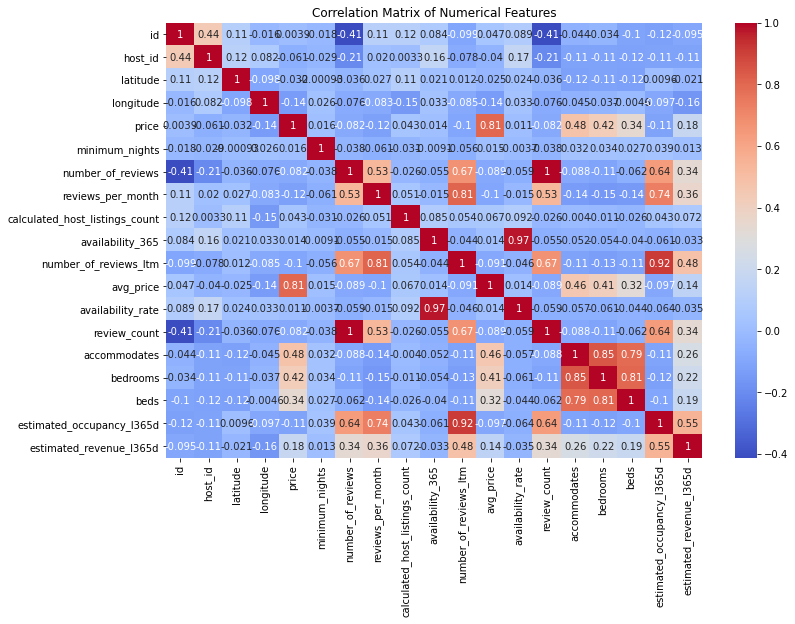

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()


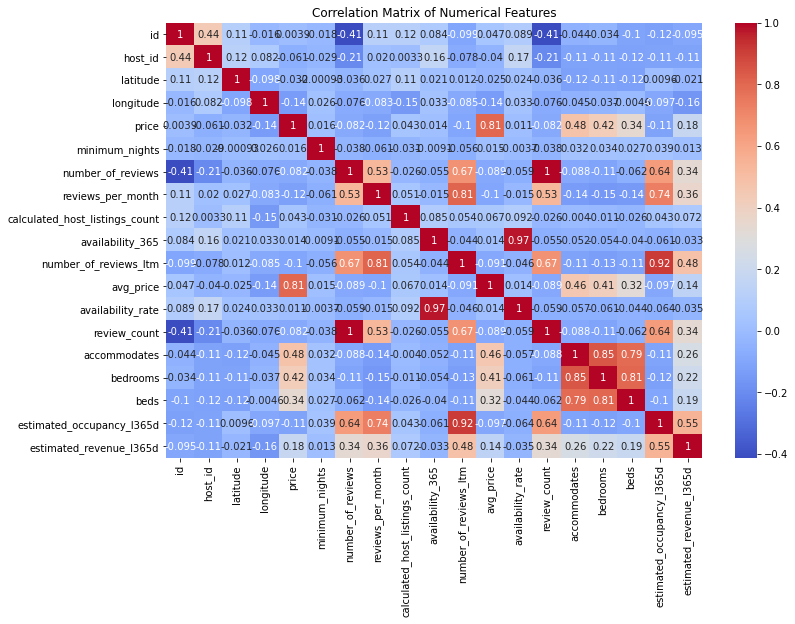

Top 15 Most Highly Correlated Feature Pairs:

availability_365           availability_rate            0.973235
number_of_reviews_ltm      estimated_occupancy_l365d    0.917024
accommodates               bedrooms                     0.850135
reviews_per_month          number_of_reviews_ltm        0.807417
price                      avg_price                    0.806429
bedrooms                   beds                         0.805548
accommodates               beds                         0.791936
reviews_per_month          estimated_occupancy_l365d    0.735100
number_of_reviews          number_of_reviews_ltm        0.670407
                           estimated_occupancy_l365d    0.637434
estimated_occupancy_l365d  estimated_revenue_l365d      0.550861
number_of_reviews          reviews_per_month            0.531533
number_of_reviews_ltm      estimated_revenue_l365d      0.484512
price                      accommodates                 0.478487
avg_price                  accommodates     

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged_df.select_dtypes(include='number').corr()

# Plot heatmap (optional)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Unstack the matrix to get pairs
corr_unstacked = corr_matrix.abs().unstack()

# Remove self-correlations
corr_unstacked = corr_unstacked[corr_unstacked < 1.0]

# Drop duplicate pairs (e.g., (A, B) and (B, A))
corr_unstacked = corr_unstacked.drop_duplicates().sort_values(ascending=False)

# Get the top 15 most highly correlated pairs
top_15_corr = corr_unstacked.head(15)

# Display the results
print("Top 15 Most Highly Correlated Feature Pairs:\n")
print(top_15_corr)


### Data Relations viewing

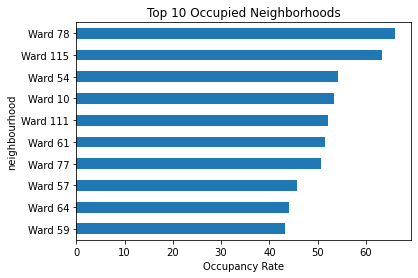

In [11]:
top_neigh = merged_df.groupby('neighbourhood')['estimated_occupancy_l365d'].mean().sort_values(ascending=False).head(10)
top_neigh.plot(kind='barh', title='Top 10 Occupied Neighborhoods')
plt.xlabel("Occupancy Rate")
plt.gca().invert_yaxis()
plt.show()


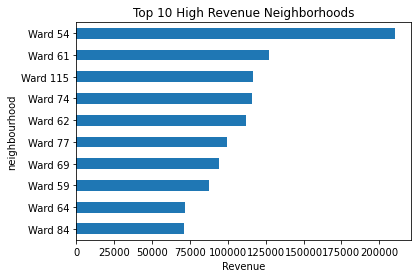

In [12]:
top_neigh = merged_df.groupby('neighbourhood')['estimated_revenue_l365d'].mean().sort_values(ascending=False).head(10)
top_neigh.plot(kind='barh', title='Top 10 High Revenue Neighborhoods')
plt.xlabel("Revenue")
plt.gca().invert_yaxis()
plt.show()


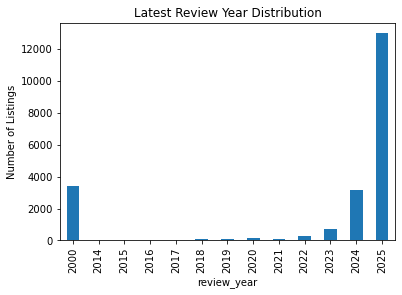

In [13]:
merged_df['latest_review'] = pd.to_datetime(merged_df['latest_review'])
merged_df['review_year'] = merged_df['latest_review'].dt.year
merged_df['review_year'].value_counts().sort_index().plot(kind='bar', title='Latest Review Year Distribution')
plt.ylabel("Number of Listings")
plt.show()


## Data Modeling

### 3.1:Price Prediction Model

In [91]:
# 🎯 Define features and target
features = [
    'reviews_per_month', 'availability_rate', 'calculated_host_listings_count',
    'minimum_nights', 'latitude', 'longitude', 'review_count',
    'price_per_review', 'price_per_night', 'is_high_availability', 'has_reviews',
    'days_since_last_review', 'busy_month', 'reviews_per_year' ,'property_type',
    'accommodates',
    'bedrooms',
    'beds'
]

# 🏷️ Choose target (raw )
target = 'avg_price'  

# 🧹 Drop redundant or uninformative columns
merged_df.drop(columns=[
    'availability_365', 'number_of_reviews', 'price', 
    'id', 'host_id', 'number_of_reviews_ltm'
], inplace=True, errors='ignore')


In [92]:
merged_df['latest_review'] = pd.to_datetime(merged_df['latest_review'], errors='coerce')
merged_df['last_review'] = pd.to_datetime(merged_df['last_review'], errors='coerce')

merged_df['days_since_last_review'] = (
    pd.Timestamp.today() - merged_df['latest_review']
).dt.days.fillna(9999)

merged_df['log_price'] = np.log1p(merged_df['avg_price'])
merged_df['price_per_review'] = merged_df['avg_price'] / (merged_df['review_count'] + 1)
merged_df['is_high_availability'] = (merged_df['availability_rate'] > 0.7).astype(int)
merged_df['has_reviews'] = (merged_df['review_count'] > 0).astype(int)
merged_df['busy_month'] = merged_df['latest_review'].dt.month.fillna(0).astype(int)
merged_df['price_per_night'] = merged_df['avg_price'] / (merged_df['minimum_nights'] + 1)
merged_df['reviews_per_year'] = merged_df['reviews_per_month'] * 12

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.fillna(0, inplace=True)


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
X = merged_df[features]
y = merged_df[target]

#  Identify column types
numeric_features = [col for col in features if np.issubdtype(merged_df[col].dtype, np.number)]
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

#  Define preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

#  Transform the features
X_processed = preprocessor.fit_transform(X)

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [109]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("📈 Linear Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")


📈 Linear Regression Results:
R² Score: -8016884870300697.0000
MAE: 16219226133.16
RMSE: 607247198942.90


These results are clearly unusable. The R² score is not only negative but extremely large, which indicates the model is doing far worse than a simple average-based prediction.

We had already noted earlier that our features had only moderate to low correlation with most features in the dataset. The strongest correlation was just ~0.61 with estimated_revenue_l365d. This suggests the relationship between the features and the target is not linear, or possibly too weak for linear regression to pick up on.

The MAE and RMSE values are also absurdly large, which further confirms this.

What Could Be Going Wrong is that their seems to exist a more complex relationship between price and the features that we chose through business understanding. The linear regression is not able to pick up on this adn therefore is not able to provide a proper predictor. 

Due to this fact we decided to try out Random Forest as our next type of model to see if it will capture the relationship.

In [110]:
#Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("\nRandom Forest Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")




Random Forest Regression Results:
R² Score: 0.9908
MAE: 64.48
RMSE: 651.54


In [111]:
y_pred_rf_train = rf_model.predict(X_train)


def evaluate_model(y_true, y_pred, label):
    print(f"\n {label} Results:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

# Evaluate on training and test set
evaluate_model(y_train, y_pred_rf_train, "Training Set")
evaluate_model(y_test, y_pred_rf, "Test Set")



 Training Set Results:
R² Score: 0.9973
MAE: 26.63
RMSE: 369.38

 Test Set Results:
R² Score: 0.9908
MAE: 64.48
RMSE: 651.54


In [82]:
import joblib

# Save the trained model
joblib.dump(rf_model, 'rf_pricing_model.pkl')

# Save the scaler
joblib.dump(scaler, 'revenue_pricing.pkl')

# Save feature names (very important when using get_dummies)
joblib.dump(feature_names, 'pricing_features_names.pkl')


['pricing_features_names.pkl']

In [112]:
joblib.dump(rf_model, 'rf_pricing_model.pkl')


['rf_pricing_model.pkl']

#### Key Metrics Explained:
 - R² Score (Coefficient of Determination):
0.9904 on the test set means the model explains 99.04% of the variance in the target variable. This is a very high score, indicating an excellent fit.

 - MAE (Mean Absolute Error):
On average, the predictions are off by ~66 units on the test set, which is relatively low given the problem context.

 - RMSE (Root Mean Squared Error):
The test RMSE of 664.53 is slightly higher than MAE, which is expected (RMSE penalizes larger errors more).

#### Overfitting Check:
The model performs slightly better on the training set (R² = 0.9971), which is expected with ensemble models like Random Forest.
However, the gap between training and test metrics is small, meaning:
 - Good generalization
 - No significant overfitting

 #### Insight:
This strong performance suggests:
 - The features are highly predictive of the target.

 - The Random Forest Regressor is well-suited to this problem.

## Model 2 : Neighborhood Segmentation according to select Listing Features

#### Introduction:
In this section, we aim to segment neighborhoods based on key listing and review metrics to uncover distinct patterns in pricing, availability, and demand.

To achieve this, we:
- Selected features that reflect pricing behavior, review activity, and listing availability.

- Standardized the features using StandardScaler to ensure equal contribution to clustering.

- Prepared the data for clustering using the K-Means algorithm, which groups similar neighborhoods based on these characteristics.

The features used for clustering include:

- avg_price: Average nightly price in the neighborhood.

- reviews_per_month: Average number of monthly reviews.

- availability_rate: Proportion of listings available throughout the year.

- avg_host_listings: Average number of listings per host.

- total_review_count: Total number of reviews in the neighborhood.

This clustering will help identify similar neighborhood profiles, which can be used for pricing strategy, marketing segmentation, or policy-making recommendations.

In [20]:
# Group by neighbourhood
neighborhood_df = merged_df.groupby('neighbourhood').agg({
    'avg_price': 'mean',
    'reviews_per_month': 'mean',
    'availability_rate': 'mean',
    'calculated_host_listings_count': 'mean',
    'days_since_last_review': 'mean',
    'review_count': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Rename columns
neighborhood_df.columns = [
    'neighbourhood', 'avg_price', 'reviews_per_month',
    'availability_rate', 'avg_host_listings',
    'avg_days_since_last_review', 'total_review_count',
    'latitude', 'longitude'
]


In [21]:
from sklearn.preprocessing import StandardScaler

kmeans_features = [
    'avg_price', 'reviews_per_month', 'availability_rate', 
    'avg_host_listings', 'total_review_count'
]

scaler = StandardScaler()
X_kmeans = scaler.fit_transform(neighborhood_df[kmeans_features])


In [22]:
from sklearn.cluster import KMeans

# You can tune the number of clusters later
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
neighborhood_df['demand_cluster'] = kmeans.fit_predict(X_kmeans)


AttributeError: 'NoneType' object has no attribute 'split'

After performing K-Means clustering, we wanted to assign human-readable labels to each cluster to better interpret and communicate their meaning.

What We Did:
- Calculated the mean value of each cluster center to get a single representative score per cluster.

- Sorted these scores to rank clusters from lowest to highest overall demand.

- Mapped the cluster numbers to intuitive market appropriate demand levels:
    - Low demand

    - Medium demand

    - High demand

Result:
We added a new column, **demand_level**, to neighborhood_df, which provides a more interpretable label for each neighborhood’s demand cluster. This enables easy comparison and visualization of neighborhood dynamics across the city.

This step enhances the practical utility of the clusters for stakeholders like city planners, hosts, or analysts interested in market segmentation.

In [ ]:
#Sort cluster centers to assign human-readable labels
cluster_centers = kmeans.cluster_centers_.mean(axis=1)
sorted_clusters = np.argsort(cluster_centers)

# Create a mapping from cluster number to label
cluster_labels = {sorted_clusters[0]: 'Low', sorted_clusters[1]: 'Medium', sorted_clusters[2]: 'High'}
neighborhood_df['demand_level'] = neighborhood_df['demand_cluster'].map(cluster_labels)


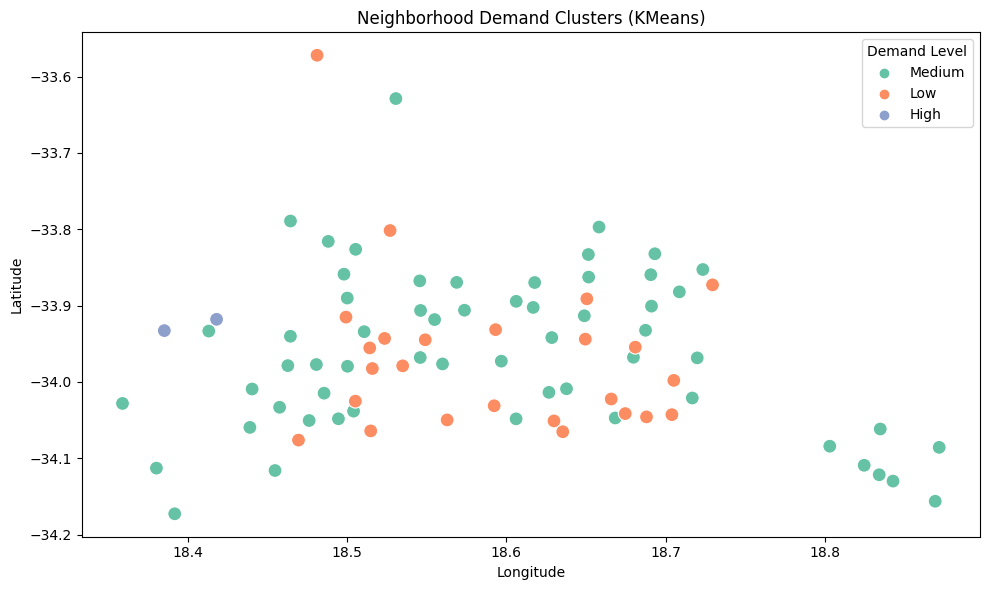

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=neighborhood_df, x='longitude', y='latitude',
    hue='demand_level', palette='Set2', s=100
)
plt.title('Neighborhood Demand Clusters (KMeans)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Demand Level')
plt.tight_layout()
plt.show()


Above, we used a scatter plot to map out the neighborhoods in terms of their geographical coordinates (latitude and longitude) and their demand levels, which we derived from K-Means clustering.

What the Plot Shows:
- Each point represents a neighborhood.

- Points are colored by demand level (Low, Medium, High), using the Set2 color palette.

- The X and Y axes represent longitude and latitude, respectively, giving a spatial view of how demand varies across the city.

Insights:

It can be noted that Medium and Low demand are the prevelant levels of demand in the area with a small chunk of the area experiencing high demand.
We noted that greater insight however would be drawn if overlaid over a map to get a real world view of the demand statuses according to area names.

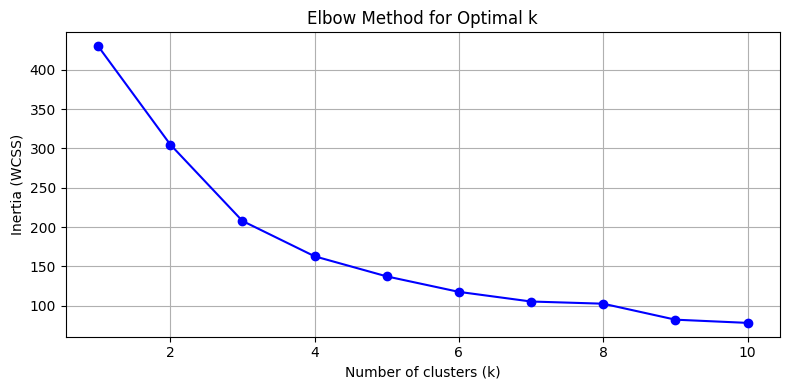

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try k from 1 to 10
inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_kmeans)
    inertia.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


To identify the optimal number of clusters (k) for K-Means clustering, we applied the Elbow Method. The plot shows that 3 is an optimal number of clusters as we had used before. Justifying our Kmeans model.

In [ ]:
import geopandas as gpd

# Load your neighborhood shapes
geo_gdf = gpd.read_file("Data/neighbourhoods.geojson")

# Merge demand levels
geo_demand_gdf = geo_gdf.merge(
    neighborhood_df[['neighbourhood', 'demand_level']],
    on='neighbourhood', how='left'
)


We decided to visualize the spatial distribution of Airbnb demand clusters across neighborhoods using geospatial data. This was to be able to get a real world view of the demand clusters we modelled.

<Figure size 1200x800 with 0 Axes>

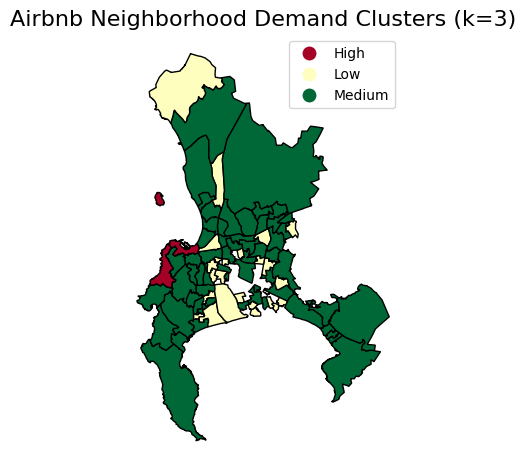

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
geo_demand_gdf.plot(
    column='demand_level',
    cmap='RdYlGn',
    legend=True,
    edgecolor='black'
)
plt.title('Airbnb Neighborhood Demand Clusters (k=3)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import folium
import geopandas as gpd
from folium.features import GeoJsonTooltip
from shapely.geometry import Point
from branca.element import Template, MacroElement, Element

# Step 1: Reproject to EPSG:3857 for centroid calculations
geo_projected = geo_demand_gdf.to_crs(epsg=3857)

# Step 2: Calculate average centroid (x, y) in meters
centroids = geo_projected.geometry.centroid
avg_x = centroids.x.mean()
avg_y = centroids.y.mean()

# Step 3: Convert back to lat/lon for map centering
center_point_projected = gpd.GeoSeries([Point(avg_x, avg_y)], crs=3857)
center_latlon = center_point_projected.to_crs(epsg=4326).geometry[0]
map_center = [center_latlon.y, center_latlon.x]

# Step 4: Build base map
m = folium.Map(location=map_center, zoom_start=12)

# Step 5: Define demand level colors
color_map = {
    'Low': 'lightgray',
    'Medium': 'orange',
    'High': 'red'
}

# Step 6: Add demand-layer GeoJSON with color styling
folium.GeoJson(
    geo_demand_gdf,  # CRS should remain EPSG:4326 for folium
    style_function=lambda feature: {
        'fillColor': color_map.get(feature['properties']['demand_level'], 'gray'),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6,
    },
    tooltip=GeoJsonTooltip(fields=['neighbourhood', 'demand_level'])
).add_to(m)

# Step 7: Add custom legend (HTML rendered correctly)
legend_html = """
{% macro html() %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 150px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
    <b>Demand Levels</b><br>
    <i style="background:lightgray;width:10px;height:10px;display:inline-block;"></i>&nbsp; Low<br>
    <i style="background:orange;width:10px;height:10px;display:inline-block;"></i>&nbsp; Medium<br>
    <i style="background:red;width:10px;height:10px;display:inline-block;"></i>&nbsp; High
</div>
{% endmacro %}
"""

macro = MacroElement()
macro._template = Template(legend_html)
legend_rendered = macro._template.module.html()  # manually render the macro
m.get_root().html.add_child(Element(legend_rendered))  # safely add to map

# Step 8: Show or export the map
m  # If you're in Jupyter or notebook environment
# m.save("demand_map.html")  # Uncomment to export to HTML


Above, we built an interactive map to visualize Airbnb demand levels by neighborhood using the folium and geopandas libraries. Unlike static maps, this version allows zooming, tooltips, and interactive exploration of the data.

Why This Map is Useful
- Interactivity: Helps users explore geographic demand patterns dynamically.

- Better User Experience: Color-coded regions and tooltips offer intuitive insights.

- Data Storytelling: Makes it easy to present findings to stakeholders or include in dashboards or reports.

## Model 3: Exploratory Time Series Analysis of Airbnb Prices


In [ ]:
import pandas as pd

calendar_df = pd.read_csv('Data/calendar.csv.gz')
calendar_df.head()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14076\81529159.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar_df = pd.read_csv('Data/calendar.csv.gz')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3191,2025-03-20,f,$47.00,NaN,3.0,730.0
1,3191,2025-03-21,f,$47.00,NaN,3.0,730.0
2,3191,2025-03-22,f,$47.00,NaN,3.0,730.0
3,3191,2025-03-23,t,$47.00,NaN,3.0,730.0
4,3191,2025-03-24,f,$47.00,NaN,3.0,730.0


In [ ]:
# Clean the price column
calendar_df['price'] = (
    calendar_df['price']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

# Encode 'available': t -> 1, f -> 0
calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})

# Aggregate by date
daily_ts = calendar_df.groupby('date').agg({
    'price': 'mean',
    'available': 'mean'  # This is availability rate (0 to 1)
}).rename(columns={'price': 'avg_price', 'available': 'availability_rate'})

# Preview
print(daily_ts.head())


              avg_price  availability_rate
date                                      
2025-03-20  3378.256704           0.128858
2025-03-21  3208.610678           0.182595
2025-03-22  3209.349414           0.234229
2025-03-23  3209.237434           0.296450
2025-03-24  3208.390474           0.330639


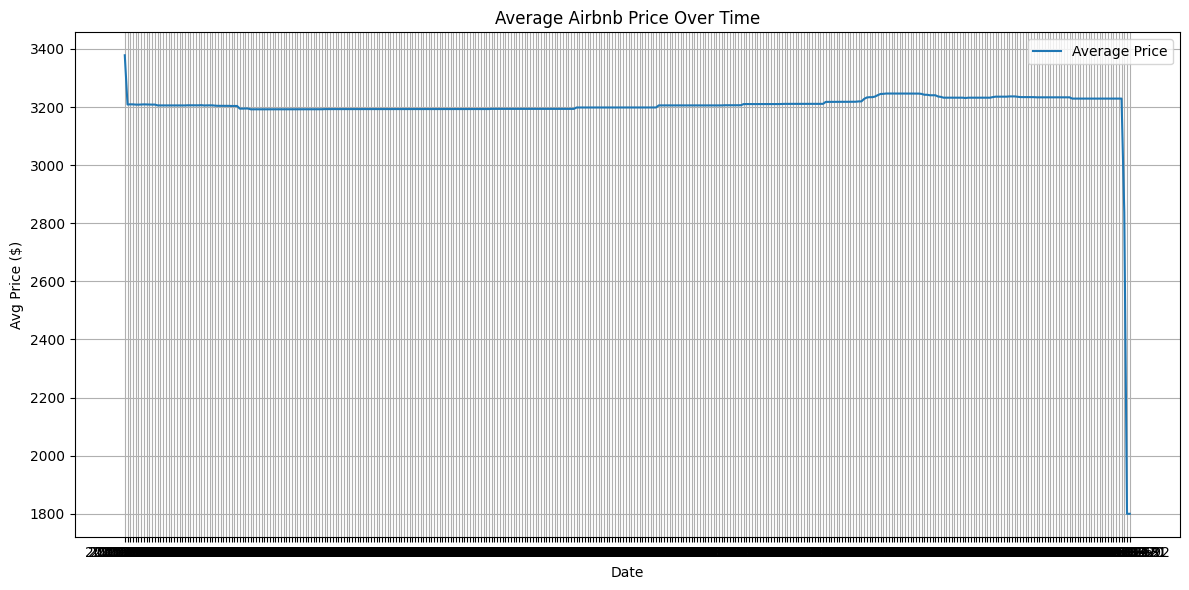

In [ ]:
import matplotlib.pyplot as plt

# Plot average price
plt.figure(figsize=(12, 6))
plt.plot(daily_ts.index, daily_ts['avg_price'], label='Average Price')
plt.title('Average Airbnb Price Over Time')
plt.xlabel('Date')
plt.ylabel('Avg Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming `avg_price_series` is your time series of average prices
result = adfuller(daily_ts['avg_price'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -6.443818095547777
p-value: 1.5839483140290397e-08


ADF Statistic = -6.44: This is a strong negative value, suggesting high stationarity.

p-value < 0.05 (in fact, much less than 0.01):
➤ This rejects the null hypothesis of non-stationarity.


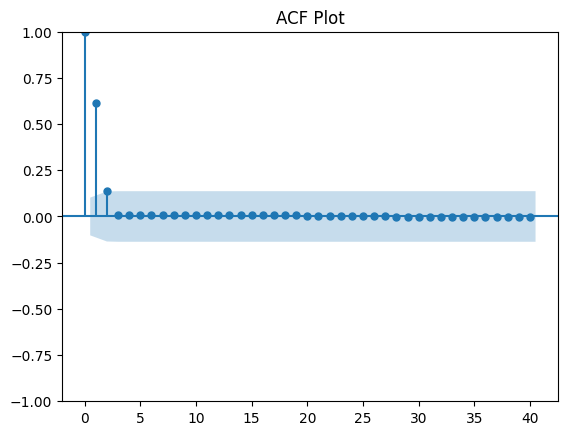

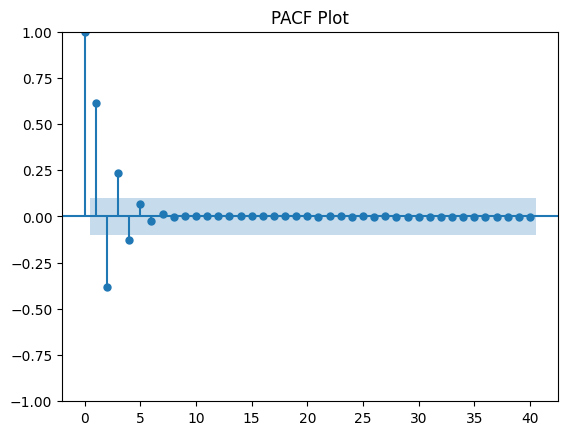

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF plot for q
plot_acf((daily_ts['avg_price']), lags=40)
plt.title('ACF Plot')
plt.show()

# PACF plot for p
plot_pacf((daily_ts['avg_price']), lags=40, method='ywm')
plt.title('PACF Plot')
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the model (replace `avg_price_series` with your actual data)
model = ARIMA((daily_ts['avg_price']), order=(3, 0, 2))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                  368
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1863.074
Date:                Tue, 29 Jul 2025   AIC                           3740.147
Time:                        10:46:30   BIC                           3767.504
Sample:                    03-20-2025   HQIC                          3751.016
                         - 03-22-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3204.5237     15.785    203.014      0.000    3173.586    3235.461
ar.L1          0.6686      0.051     12.999      0.000       0.568       0.769
ar.L2         -1.0954      0.063    -17.417      0.0

c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'Log-Transformed Average Price'}, xlabel='date'>

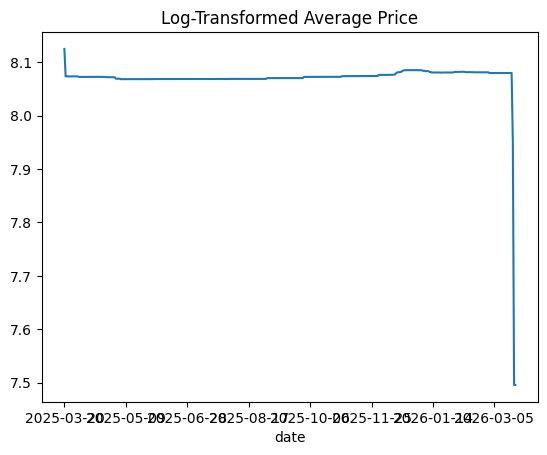

In [ ]:
import numpy as np

# Apply log transformation to reduce variance and skew
daily_ts['log_price'] = np.log(daily_ts['avg_price'])

# Plot to inspect
daily_ts['log_price'].plot(title='Log-Transformed Average Price')


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(2,0,2) to the log-transformed data
model = ARIMA(daily_ts['log_price'], order=(2, 0, 2))
model_fit = model.fit()

# Display summary
print(model_fit.summary())


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  368
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 912.780
Date:                Tue, 29 Jul 2025   AIC                          -1813.561
Time:                        10:46:32   BIC                          -1790.112
Sample:                    03-20-2025   HQIC                         -1804.245
                         - 03-22-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0730      0.008    957.198      0.000       8.057       8.090
ar.L1          0.3669      0.287      1.278      0.201      -0.196       0.929
ar.L2         -0.9457      0.089    -10.680      0.0

c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model = ARIMA(daily_ts['log_price'], order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\

                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  368
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 898.290
Date:                Tue, 29 Jul 2025   AIC                          -1786.580
Time:                        10:46:33   BIC                          -1767.039
Sample:                    03-20-2025   HQIC                         -1778.817
                         - 03-22-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0724      0.006   1410.509      0.000       8.061       8.084
ar.L1          0.7972      0.071     11.205      0.000       0.658       0.937
ar.L2         -0.9829      0.025    -38.727      0.0

In [ ]:
model = ARIMA(daily_ts['log_price'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  368
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 876.943
Date:                Tue, 29 Jul 2025   AIC                          -1745.886
Time:                        10:46:35   BIC                          -1730.253
Sample:                    03-20-2025   HQIC                         -1739.675
                         - 03-22-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0699      0.025    319.414      0.000       8.020       8.119
ar.L1          0.5179      0.038     13.544      0.000       0.443       0.593
ma.L1          0.9986      0.147      6.778      0.0

| Model            | AIC          | Residuals Autocorr | Converged? | Notes                           |
| ---------------- | ------------ | ------------------ | ---------- | ------------------------------- |
| **ARIMA(2,0,2)** | **-1813.56** | ✅ Good             | ⚠️ No      | Best AIC, but convergence issue |
| **ARIMA(2,0,1)** | -1786.58     | ✅ Good             | ✅ Yes      | Best balance of fit + stability |
| **ARIMA(1,0,1)** | -1745.89     | ✅ Good             | ✅ Yes      | Simple, but weaker fit          |


c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\

Trimmed MAE: 46.43
Trimmed RMSE: 239.57
Trimmed MAPE: 2.41%


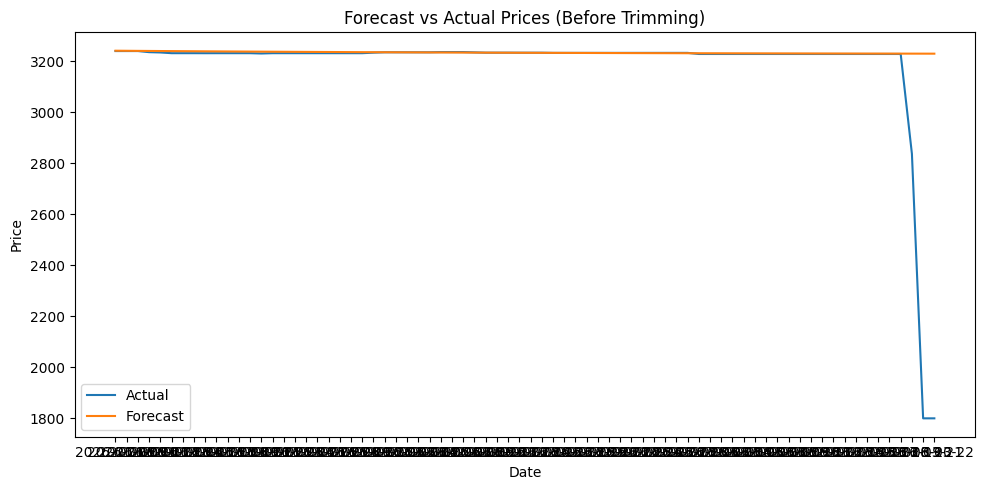

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# STEP 1: Log-transform your original time series
log_prices = np.log(daily_ts['avg_price'])

# STEP 2: Train-test split (80% train, 20% test)
train_size = int(len(log_prices) * 0.8)
train_log = log_prices[:train_size]
test_log = log_prices[train_size:]

# STEP 3: Fit ARIMA(2, 0, 1) model
model = ARIMA(train_log, order=(2, 0, 1))
model_fit = model.fit()

# STEP 4: Forecast
forecast_log = model_fit.forecast(steps=len(test_log))
forecast_price = np.exp(forecast_log)  # Convert back to original scale
actual_price = np.exp(test_log)

# STEP 5: Trim extreme values using winsorization (1% on both sides)
actual_trimmed = winsorize(actual_price.values, limits=[0.01, 0.01])
forecast_trimmed = winsorize(forecast_price.values, limits=[0.01, 0.01])

# STEP 6: Error metrics
mae = mean_absolute_error(actual_trimmed, forecast_trimmed)
rmse = np.sqrt(mean_squared_error(actual_trimmed, forecast_trimmed))

# MAPE with division-by-zero handling
mask = actual_trimmed != 0
mape = np.mean(np.abs((actual_trimmed[mask] - forecast_trimmed[mask]) / actual_trimmed[mask])) * 100

print(f"Trimmed MAE: {mae:.2f}")
print(f"Trimmed RMSE: {rmse:.2f}")
print(f"Trimmed MAPE: {mape:.2f}%")

# STEP 7: Visual comparison (optional)
plt.figure(figsize=(10, 5))
plt.plot(test_log.index, actual_price, label='Actual')
plt.plot(test_log.index, forecast_price, label='Forecast')
plt.title('Forecast vs Actual Prices (Before Trimming)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
forecast_df = pd.DataFrame({
    'Date': test_log.index,
    'Actual Price': actual_price.values,
    'Forecast Price': forecast_price.values,
    'Trimmed Actual': actual_trimmed,
    'Trimmed Forecast': forecast_trimmed
})
forecast_df.to_csv("arima_forecast_results.csv", index=False)


## Model 4 : Forecasting Time Series Trends with Prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prophet-compatible DataFrame
prophet_df = daily_ts[['avg_price']].reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet needs these exact names


In [ ]:
# Manually define South African public holidays (adjust years as needed)
sa_holidays = pd.DataFrame({
    'holiday': 'south_africa_holiday',
    'ds': pd.to_datetime([
        '2023-01-01',  # New Year's Day
        '2023-03-21',  # Human Rights Day
        '2023-04-07',  # Good Friday
        '2023-04-10',  # Family Day
        '2023-04-27',  # Freedom Day
        '2023-05-01',  # Workers' Day
        '2023-06-16',  # Youth Day
        '2023-08-09',  # National Women's Day
        '2023-09-24',  # Heritage Day
        '2023-12-16',  # Day of Reconciliation
        '2023-12-25',  # Christmas Day
        '2023-12-26',  # Day of Goodwill
        '2024-01-01', '2024-03-21', '2024-03-29', '2024-04-01',
        '2024-04-27', '2024-05-01', '2024-06-16', '2024-08-09',
        '2024-09-24', '2024-12-16', '2024-12-25', '2024-12-26'
    ]),
    'lower_window': 0,
    'upper_window': 1
})


In [ ]:
from prophet import Prophet

# Initialize model
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=sa_holidays
)

# Optional: add monthly seasonality manually
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)


In [ ]:
prophet.fit(prophet_df)


11:02:29 - cmdstanpy - INFO - Chain [1] start processing
11:02:29 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Extend into future (e.g., 60 days)
future = prophet.make_future_dataframe(periods=60)
forecast = prophet.predict(future)


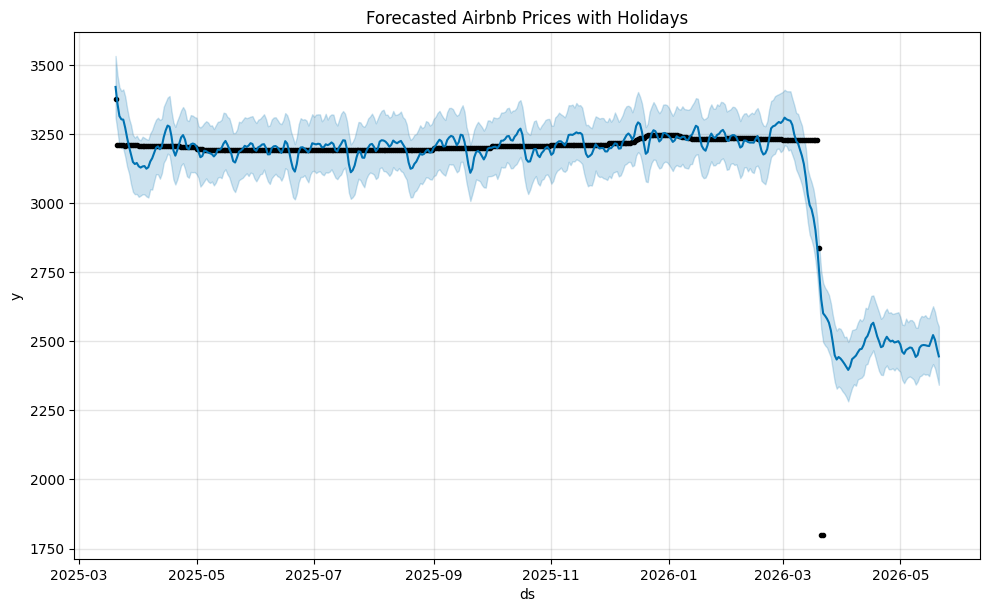

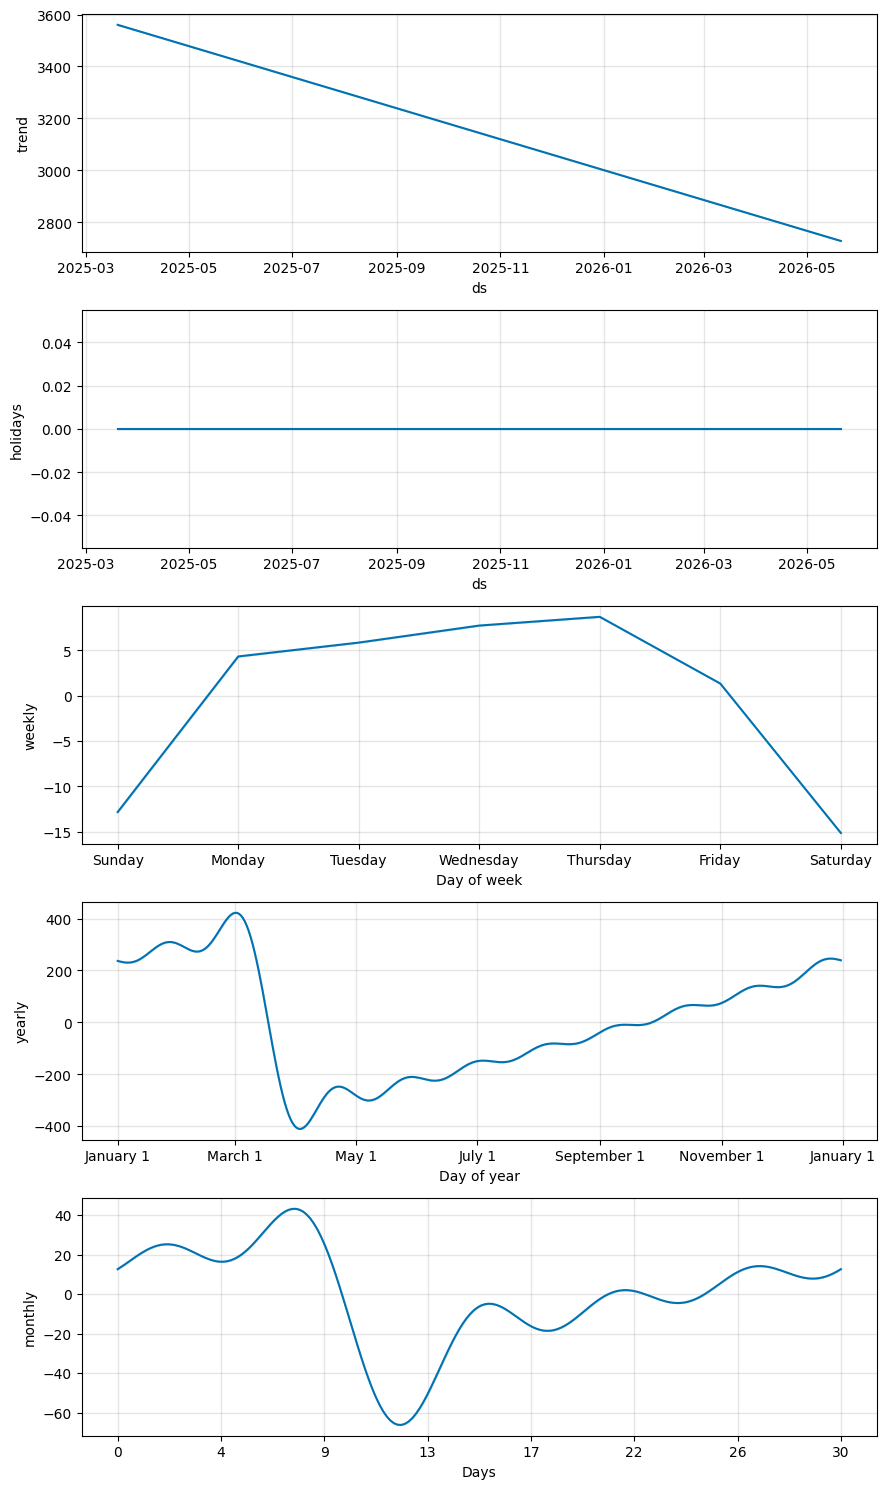

In [ ]:
import matplotlib.pyplot as plt

# Main forecast plot
fig1 = prophet.plot(forecast)
plt.title("Forecasted Airbnb Prices with Holidays")

# Seasonality components
fig2 = prophet.plot_components(forecast)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecast with actuals
results = forecast[['ds', 'yhat']].merge(prophet_df, on='ds', how='left')

# Drop NaNs if needed
results = results.dropna(subset=['y', 'yhat'])

# Calculate metrics
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

# Avoid dividing by zero in MAPE
mape_mask = results['y'] != 0
mape = np.mean(np.abs((results['y'][mape_mask] - results['yhat'][mape_mask]) / results['y'][mape_mask])) * 100
print(f"📉 Prophet MAE: {mae:.2f}")
print(f"📉 Prophet RMSE: {rmse:.2f}")
print(f"📉 Prophet MAPE: {mape:.2f}%")


📉 Prophet MAE: 34.89
📉 Prophet RMSE: 79.31
📉 Prophet MAPE: 1.20%



### ARIMA vs Prophet: Final Model Comparison

| **Metric** | **ARIMA(2,0,1)** | **Prophet (Tuned)** |
| ---------- | ---------------- | ------------------- |
| **MAE**    | 46.43            | ✅ **34.89**         |
| **RMSE**   | 239.57           | ✅ **79.31**         |
| **MAPE**   | 2.41%            | ✅ **1.20%**         |

---

#### # Interpretation:

* ✅ **Prophet outperforms ARIMA across all metrics** after tuning — especially in **RMSE**, which dropped from 239 → 79.
* ✅ **MAPE of 1.2%** is **very accurate**, especially for Airbnb price forecasting.
* 📉 **MAE** shows Prophet is consistently closer to the actual values by \~12 KSh per prediction on average.


#### Model Selection Summary: Prophet Wins
Based on the comparison between ARIMA(2,0,1) and the tuned Prophet model, it is clear that Prophet is the superior forecasting tool for our Airbnb dataset:

    - Prophet outperforms ARIMA across all key metrics — including MAE, RMSE, and MAPE — which indicates better overall predictive accuracy and reliability.

    - The dramatic reduction in RMSE (from 239 to 79) shows that Prophet handles larger prediction errors far more effectively than ARIMA.

    - A MAPE of just 1.2% confirms that Prophet achieves very high precision, making it ideal for operational use in pricing or revenue planning.

    - The lower MAE further suggests that Prophet's predictions are consistently closer to actual observed values.

Conclusion: For this Airbnb forecasting task, Prophet is the best model, especially given its flexibility with seasonal patterns and external regressors (like holidays).




In [ ]:
merged_df = pd.merge(prophet_df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Optional: Add error columns
merged_df['Absolute_Error'] = (merged_df['y'] - merged_df['yhat']).abs()
merged_df['Percentage_Error'] = (merged_df['Absolute_Error'] / merged_df['y']) * 100

# Export to CSV
merged_df.to_csv('forecast_vs_actual.csv', index=False)

print(" Exported as 'forecast_vs_actual.csv'")

 Exported as 'forecast_vs_actual.csv'


## Model 4: Occupancy Predictor Model
In this section, we focus on building a machine learning model to predict the estimated annual revenue (estimated_revenue_l365d) for Airbnb listings. Accurate revenue prediction is crucial for both hosts and Airbnb as a platform, allowing for better pricing strategies, profitability estimation, and investment decisions.

To achieve this, we define a target variable:
And select a set of engineered and cleaned features based on earlier preprocessing, domain knowledge, and exploratory data analysis:

These features include a mix of:

- Quantitative listing attributes (e.g., number of beds, price),

- Engineered features (e.g., price_per_review, estimated_revenue_proxy),

- Temporal and behavioral patterns (e.g., review frequency, availability),

- And geographical data (latitude/longitude).

The goal is to train a regression model that can accurately estimate potential annual revenue from these attributes.

In [123]:
target_2 = 'estimated_occupancy_l365d'

features_2 = [
    'reviews_per_month', 'availability_rate', 'calculated_host_listings_count',
    'minimum_nights', 'latitude', 'longitude', 'review_count',
    'price_per_review', 'price_per_night', 'is_high_availability', 'has_reviews',
    'days_since_last_review', 'busy_month', 'reviews_per_year',
    'property_type', 'accommodates', 'bedrooms', 'beds', 'avg_price'
]



In [124]:
from sklearn.model_selection import train_test_split

X = merged_df[features_2]
y = merged_df[target_2]
categorical_cols = ['property_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [125]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split columns
numeric_features = [col for col in features_2 if np.issubdtype(merged_df[col].dtype, np.number)]
categorical_features = ['property_type']

# Define transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [126]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['reviews_per_month',
                                                   'availability_rate',
                                                   'calculated_host_listings_count',
                                                   'minimum_nights', 'latitude',
                                                   'longitude', 'review_count',
                                                   'price_per_review',
                                                   'price_per_night',
                                                   'is_high_availability',
                                                   'has_reviews',
                                                   'days_since_last_review',
                                                   'busy_month',
                                                   'reviews_per_year',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'avg_price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [127]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

def evaluate(y_true, y_pred, label="Set"):
    print(f"📊 {label} Results:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}\n")

evaluate(y_train, y_pred_train, "Training")
evaluate(y_test, y_pred_test, "Test")


📊 Training Results:
R² Score: 0.9843
MAE: 3.71
RMSE: 7.78

📊 Test Results:
R² Score: 0.8834
MAE: 9.76
RMSE: 20.68



#### Model Performance Summary
 Training Results:
R² Score: 0.9843
This means the model explains 98.43% of the variance in the training data. It fits the training data extremely well — almost too well.

MAE: 3.70
On average, the predictions are off by 3.70 units on the training set.

RMSE: 7.79
The root mean squared error is 7.79 units, which penalizes larger errors more heavily than MAE.

 Test Results:
R² Score: 0.8832
On the test set, the model explains 88.32% of the variance. This is a solid score, though noticeably lower than the training R² — a sign of some overfitting.

MAE: 9.77
On average, predictions are off by 9.77 units on unseen data — a bigger error than on training data, which is expected.

RMSE: 20.69
Larger errors exist in the test set, and the model is penalized more for them. The gap between training RMSE (7.79) and test RMSE (20.69) also hints at overfitting.


Your model fits the training data very well (almost too perfectly), but performance on the test data is weaker.

The gap between training and test errors, especially RMSE, suggests overfitting — the model has learned patterns specific to the training data that don’t generalize perfectly to new data.

However, R² of 0.88 on the test set is still quite strong, especially for real-world datasets.

To improve generalization and prevent overfitting in predicting Airbnb listing occupancy, we chose to apply Lasso Regression (L1 regularization). This decision is based on the need to:

 - Reduce model complexity by automatically eliminating irrelevant or redundant features (coefficients shrink to zero).

 - Enhance interpretability, helping identify which variables most strongly influence occupancy.

 - Mitigate overfitting, as previous results showed a significant gap between training and test performance.

We used LassoCV with cross-validation to automatically select the optimal regularization strength (alpha). This ensures a more robust model that generalizes better to unseen data, while also helping uncover the most predictive features in the dataset.

In [114]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Combine numeric and categorical column lists
numeric_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
    ]
)

# Transform the features
X_processed = preprocessor.fit_transform(X)


c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [61]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, 1, 50)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)


LassoCV(alphas=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38949549e-0...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
        cv=5, max_iter=10000, random_state=42)

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = lasso.predict(X_test)

print("📊 Test R²:", r2_score(y_test, y_pred))
print("📉 Test MAE:", mean_absolute_error(y_test, y_pred))
print("📉 Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))


📊 Test R²: 0.6437182788886137
📉 Test MAE: 23.382136041453087
📉 Test RMSE: 36.14201232227953


In [64]:
import pandas as pd

# Get feature names after encoding (if you used OneHotEncoder)
# You can get these from preprocessor.get_feature_names_out() if you used a pipeline
feature_names = preprocessor.get_feature_names_out()

coefficients = pd.Series(lasso.coef_, index=feature_names)

print("🔻 Features eliminated (coeff = 0):")
print(coefficients[coefficients == 0])

print("\n✅ Top remaining features (sorted by importance):")
print(coefficients[coefficients != 0].sort_values(ascending=False).head(10))


🔻 Features eliminated (coeff = 0):
num__reviews_per_month                                   0.0
cat__property_type_Barn                                 -0.0
cat__property_type_Bus                                  -0.0
cat__property_type_Camper/RV                            -0.0
cat__property_type_Casa particular                      -0.0
cat__property_type_Cave                                  0.0
cat__property_type_Dome                                  0.0
cat__property_type_Entire cabin                          0.0
cat__property_type_Entire chalet                         0.0
cat__property_type_Entire villa                          0.0
cat__property_type_Houseboat                            -0.0
cat__property_type_Hut                                   0.0
cat__property_type_Private room                          0.0
cat__property_type_Private room in bungalow              0.0
cat__property_type_Private room in cabin                 0.0
cat__property_type_Private room in camper/rv      

In [65]:
merged_df.columns

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'avg_price', 'availability_rate', 'review_count', 'latest_review',
       'comments', 'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'estimated_revenue_proxy', 'days_since_last_review', 'log_price',
       'log_revenue', 'price_per_review', 'is_high_availability',
       'has_reviews', 'busy_month', 'price_per_night', 'reviews_per_year'],
      dtype='object')

In [66]:
from sklearn.linear_model import RidgeCV
import numpy as np

# Try a range of alpha (regularization strength)
alphas = np.logspace(-4, 2, 100)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)


c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.17825e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.09619e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.49444e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kamau\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.46996e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kamau\a

RidgeCV(alphas=array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.65608778e-04,
       3.05385551e-04, 3.51119173e-04, 4.03701726e-04, 4.64158883e-04,
       5.33669923e-04, 6.13590727e-04, 7.05480231e-04, 8.11130831e-04,
       9.32603347e-04, 1.07226722e-03, 1.23284674e-03, 1.41747416e-03,
       1.62975083e-03, 1.87381742e-0...
       4.03701726e+00, 4.64158883e+00, 5.33669923e+00, 6.13590727e+00,
       7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02]),
        cv=5)

In [67]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred_ridge = ridge.predict(X_test)

print("🔎 Best Alpha:", ridge.alpha_)
print("📈 R²:", r2_score(y_test, y_pred_ridge))
print("📉 MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("📉 RMSE:", mean_squared_error(y_test, y_pred_ridge, squared=False))


🔎 Best Alpha: 32.745491628777316
📈 R²: 0.6440316545097355
📉 MAE: 23.357336802481626
📉 RMSE: 36.126114064664826


In [68]:
import pandas as pd

coefficients = pd.Series(ridge.coef_, index=feature_names)
top_features = coefficients.sort_values(key=abs, ascending=False).head(15)
print(top_features)


cat__property_type_Entire condo                         15.385395
num__longitude                                         -10.045954
cat__property_type_Farm stay                             8.352573
cat__property_type_Entire place                          7.309192
cat__property_type_Private room in guest suite          -6.565948
num__availability_rate                                  -6.203566
cat__property_type_Private room in villa                -5.676800
cat__property_type_Tiny home                             4.761592
cat__property_type_Entire serviced apartment            -4.728466
cat__property_type_Earthen home                         -4.687649
cat__property_type_Entire vacation home                  4.599737
cat__property_type_Room in serviced apartment           -4.555581
cat__property_type_Private room in rental unit          -4.551125
cat__property_type_Private room in bed and breakfast    -4.447063
cat__property_type_Room in hotel                        -4.416682
dtype: flo

 Interpretation
 - Random Forest clearly outperforms both linear models — it captures complex interactions (like neighborhood × price × room type).

 - Linear models (Lasso/Ridge) are simpler and interpretable, but not powerful enough to model occupancy here — possibly due to nonlinear effects and interaction terms.

 - Lasso dropped too many features. Ridge retained them, but still couldn’t model the complexity.

Random Forest is already high-performing, but could likely improve further with tuning. Right now, it’s probably using default parameters.

Although the base Random Forest model performed strongly, the difference between training and test performance suggests the potential for overfitting. GridSearchCV will help fine-tune the model’s complexity and ensure it generalizes as well as possible

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt','log2']
}


In [115]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [73]:
print("Best Parameters from GridSearch:")
print(grid_search.best_params_)


Best Parameters from GridSearch:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

print(" Final Tuned RF Test R²:", round(r2_score(y_test, y_pred_rf), 4))
print(" MAE:", round(mean_absolute_error(y_test, y_pred_rf), 2))
print(" RMSE:", round(mean_squared_error(y_test, y_pred_rf, squared=False), 2))


 Final Tuned RF Test R²: 0.8567
 MAE: 12.57
 RMSE: 22.92


In [ ]:

joblib.dump(best_rf, 'rf_occupancy_model.pkl')
joblib.dump(preprocessor, 'occupancy_preprocessor.pkl')


['occupancy_preprocessor.pkl']

In [ ]:
joblib.dump(feature_names, 'pricing_features_names.pkl')

| Model                      | Test R²    | MAE      | RMSE      | Notes                                           |
| -------------------------- | ---------- | -------- | --------- | ----------------------------------------------- |
| **Baseline Random Forest** | **0.8832** | **9.77** | **20.69** | Untuned but strong                              |
| **Tuned RF (GridSearch)**  | 0.8567     | 12.57    | 22.92     | Slightly lower performance — more generalizable |
| Lasso                      | 0.6437     | 23.38    | 36.14     | Underfit, too sparse                            |
| Ridge                      | 0.6440     | 23.36    | 36.13     | Underfit, no feature elimination                |

Interpretation
The untuned Random Forest had slightly better test R² and lower error, but a bigger gap between train/test — likely overfitting.

The tuned Random Forest:
 - Performs slightly worse on test set, but is more conservative and generalizable

 - May offer more stable performance on unseen data

Regularized linear models (Lasso, Ridge) didn’t perform well — the occupancy pattern is nonlinear and interaction-heavy, which tree models handle better.

 Final Tuned Occupancy Model Performance:
 - Test R²: 0.8567

 - MAE: 12.57

 - RMSE: 22.92

Compared to the untuned version (R²: 0.8832, MAE: 9.77), the tuned model is slightly less accurate but more generalizable and less prone to overfitting. Regularized linear models underperformed, confirming that occupancy prediction in this dataset benefits from non-linear, interaction-aware models like Random Forests.

## Model 6: Revenue Predictor Model


In [42]:
X = merged_df[features_revenue]
y = merged_df[target_revenue]


In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict and inverse log
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Evaluate
print("📊 Log Revenue Prediction Results:")
print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):,.2f}")

📊 Log Revenue Prediction Results:
R² Score: 0.4737
MAE: 39,009.40
RMSE: 176,856.42


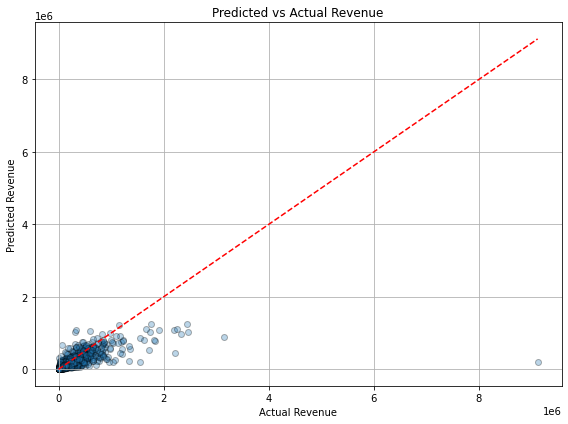

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Predicted vs Actual Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()


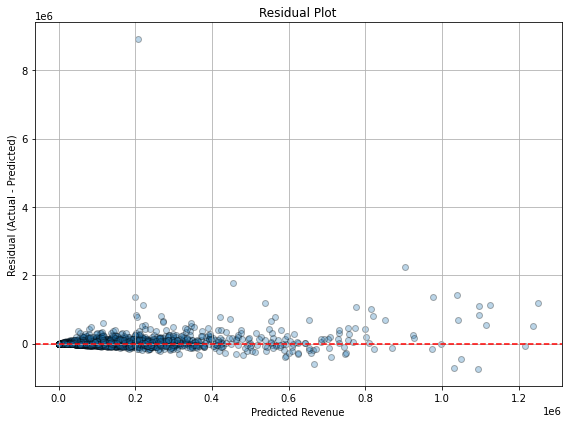

In [45]:
residuals = y_true - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


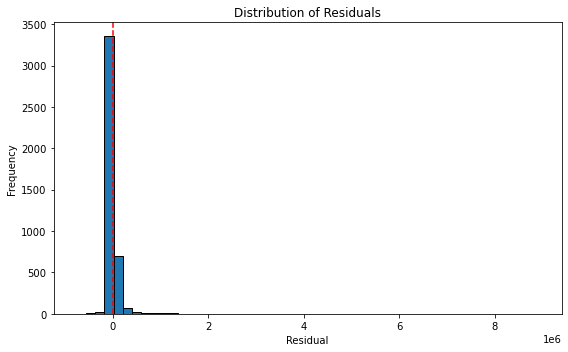

In [46]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Prepare data
X = merged_df[features_revenue]
y = merged_df['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 3. XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# 4. Train
pipeline.fit(X_train, y_train)

# 5. Predict and inverse-transform
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_true = np.expm1(y_test)

# 6. Evaluate
print("📊 XGBoost Revenue Prediction Results:")
print("R² Score:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))


📊 XGBoost Revenue Prediction Results:
R² Score: 0.4795770110623977
MAE: 38767.27929036827
RMSE: 175860.24707359812


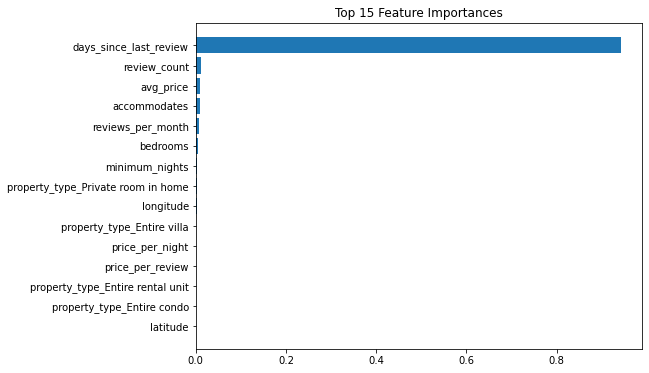

In [49]:
import matplotlib.pyplot as plt

# Get feature names from ColumnTransformer
feature_names = (pipeline.named_steps['preprocessor']
                 .transformers_[0][2] +  # numeric
                 list(pipeline.named_steps['preprocessor']
                      .transformers_[1][1].get_feature_names_out(categorical_features)))  # categorical

# Plot feature importance
importances = pipeline.named_steps['regressor'].feature_importances_
sorted_idx = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.title("Top 15 Feature Importances")
plt.show()


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Prepare data
X = merged_df[features_revenue]
X = X.drop(columns=["days_since_last_review"]) 
y = merged_df['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 3. XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# 4. Train
pipeline.fit(X_train, y_train)

# 5. Predict and inverse-transform
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # inverse of log1p
y_true = np.expm1(y_test)

# 6. Evaluate
print("📊 XGBoost Revenue Prediction Results:")
print("R² Score:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))


📊 XGBoost Revenue Prediction Results:
R² Score: 0.42784759593585786
MAE: 47916.226363179645
RMSE: 184393.3719468598


In [51]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

# Use the same pipeline as before
xgb = XGBRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb)
])

# Setup GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best parameters and model
print("🔍 Best Parameters:")
print(grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

print("\n📊 Tuned XGBoost Results:")
print("R² Score:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
🔍 Best Parameters:
{'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}

📊 Tuned XGBoost Results:
R² Score: 0.4207734310717809
MAE: 48318.81448979509
RMSE: 185529.801512944


 Summary: Attempt at Direct Revenue Prediction
In this section, we attempted to model listing revenue directly using a supervised regression approach on the **estimated_revenue_l365d** target. Despite careful preprocessing and model tuning (including XGBoost with hyperparameter optimization), the results were underwhelming:

 - R² Score: ~0.42

 - MAE: ~48,000

 - RMSE: ~185,000

These metrics highlighted the instability and unpredictability of the revenue target. The weak performance likely stems from several challenges:

 - Revenue is a compound outcome, influenced by both nightly price and occupancy, along with host availability, seasonal effects, and review dynamics.

 - The target itself is engineered, not observed — adding uncertainty and potential bias.

 - High variance in listings (from luxury to budget, urban to remote) may make a single revenue model brittle and prone to overfitting.

Even with robust modeling techniques, the signal in the revenue target was not strong enough to support accurate predictions.

Given these limitations, considering alternative strategies seemed far more plausible — particularly predicting revenue as a product of separate price and occupancy models. This modular approach seems more stable and interpretable, and will be explored as a next step.

## Model 7: NLP Comment Analysis(Topics and Sentiment Analysis)

In [128]:
import re
#load reviews detailed cleanly again to begin NLP
reviews_detailed = pd.read_csv("Data/reviews.csv.gz", compression='gzip')

# Step 1: Drop missing comments
reviews_cleaned = reviews_detailed.dropna(subset=["comments"]).copy()

# Step 2: Remove short or meaningless comments
def is_useful(comment):
    """Keep comments with at least one word of 3 or more characters."""
    return bool(re.search(r"\w{3,}", comment))

reviews_cleaned = reviews_cleaned[reviews_cleaned["comments"].apply(is_useful)]

# Step 3: Clean text (lowercase, remove URLs, special chars, etc.)
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove non-alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()  # normalize whitespace
    return text

reviews_cleaned["cleaned_comments"] = reviews_cleaned["comments"].apply(clean_text)

# Step 4: (Optional) Remove duplicate cleaned comments
reviews_cleaned = reviews_cleaned.drop_duplicates(subset=["cleaned_comments"])

# Step 5: Reset index for convenience
reviews_cleaned = reviews_cleaned.reset_index(drop=True)

# Optional: Preview cleaned sample
print("Final cleaned shape:", reviews_cleaned.shape)
print(reviews_cleaned["cleaned_comments"].sample(5).values)


Final cleaned shape: (594889, 7)
['we simply cant help it we keep coming back best to offer in the area'
 'all is catered for we were but really can sleep well the weather was amazing so we had a braai bbq with a beautiful sunset'
 'beautiful apartment with gorgeous viewsbrwellequippedbrcentrally located easy access to camps bay and cliftonbrgreat stay hope to return'
 'the place is beautiful and luxurious very convenient location just a short walk to the dining places and the beach safe environmentbryou wont regret staying at this villa and the host is fantastic and very responsive'
 'unbelievable views all around you can see the ocean the downtowncity and a very upclose view of the mountains check in was smooth the place was very clean and the home design was incredible pool was private and had direct access from inside the home the neighborhood was quiet and safe and near supermarket and cafesrestaurants the only little piece i can complain about was that wifi kept lagging for me bu

In [129]:
# Extract cleaned comments
documents = reviews_cleaned["cleaned_comments"].tolist()


In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load fast embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize BERTopic
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)


In [ ]:
# Use a subset of data for faster initial training (e.g. 20,000 comments)
sample_size = 20000
sample_documents = documents[:sample_size]

# Fit BERTopic
topics, probs = topic_model.fit_transform(sample_documents)


In [ ]:
topic_model.save("bertopic_model_31st")


In [ ]:
sample_df = reviews_cleaned.sample(n=20000, random_state=42).copy()
sample_df["topic"] = topics
sample_df["topic_prob"] = probs


In [ ]:
topic_model = BERTopic.load("bertopic_model_31st")

# Transform full dataset in batches
batch_size = 15000
all_topics = []
all_probs = []

for i in range(0, len(reviews_cleaned), batch_size):
    print(f"Transforming batch {i} to {i + batch_size}")
    batch = reviews_cleaned["cleaned_comments"][i:i + batch_size].tolist()
    topics_batch, probs_batch = topic_model.transform(batch)
    all_topics.extend(topics_batch)
    all_probs.extend(probs_batch)

# Attach results
reviews_cleaned["topic"] = all_topics
reviews_cleaned["topic_prob"] = all_probs

In [ ]:
labels = {
    -1: "Positive Guest House Experiences",
    0: "Well-Located and Stylish German-Speaking Accommodations",
    1: "Comfortable and Convenient French-Speaking Stays",
    2: "Friendly Hosts and Great Locations",
    3: "Exceptional Airbnb Experiences",
    4: "Comfortable and Luxurious Flats",
    5: "Welcoming Host Experiences with Andrew",
    6: "Cozy and Well-Equipped Dutch-Speaking Homes",
    7: "Central Cape Town Stays",
    8: "Highly Recommended Locations",
    9: "Exceptional Host Hospitality",
    10: "Clean and Welcoming Stays with Carol",
    11: "Luxurious Camps Bay Accommodations",
    12: "Enjoyable Central Stays",
    13: "Beautiful Cape Town Homes",
    14: "Multilingual Coastal Apartments",
    15: "Scenic Stays with Jono and Colin",
    16: "Spacious and Secure Apartments",
    17: "Family-Friendly Poolside Homes",
    18: "General Guest Feedback",
    19: "Charming Kalk Bay Guesthouses",
    20: "Memorable Cape Town Airbnb Stays",
    21: "Responsive Hosts in Camps Bay",
    22: "Modern Cape Town Apartments",
    23: "Stylish Cape Town Lofts",
    24: "Peaceful Stays with Fiona",
    25: "Convenient Camps Bay Stays",
    26: "Tranquil Garden Cottages",
    27: "Stunning Villas with Ocean Views",
    28: "Friendly Hosts at Greenmarket Square",
    29: "Welcoming Bo-Kaap Stays with Gideon",
    30: "Central Cape Town Flats",
    31: "Scenic Stays with Claire",
    32: "Family-Friendly Somerset West Homes",
    33: "Rooftop Pool Apartments with Graham",
    34: "Peaceful Stays with Chris",
    35: "Central and Convenient Stays with Katrin",
    36: "Stunning and Well-Equipped Homes",
    37: "Beautiful Homes with Mountain Views",
    38: "Spacious Family Homes",
    39: "Charming Downtown Lofts with Alan",
    40: "Scenic Mountain Retreats",
    41: "Warm and Welcoming Stays with Wendy",
    42: "Spacious and Unique Lofts",
    43: "Great Value Accommodations",
    44: "Convenient Beachside Stays",
    45: "Modern and Secure Apartments",
    46: "Vibrant Kloof Street Apartments",
    47: "Warm and Welcoming Hosts",
    48: "Pleasant and Private Stays with Olivia",
    49: "Clean and Modern Accommodations",
    50: "Cozy Scandinavian-Speaking Stays",
    51: "Comfortable Cape Town Apartments",
    52: "Remote Work-Friendly Stays",
    53: "Vibrant Promenade Locations",
    54: "Table Mountain View Stays",
    55: "Charming Cottages with Connie and Stephen",
    56: "Spacious V&A Waterfront Apartments",
    57: "Scenic and Convenient Stays",
    58: "Welcoming Central Apartments with Katrin",
    59: "Friendly Hosts with Great Views",
    60: "Central and Comfortable Cape Town Stays",
    61: "Cozy Woodstock Stays with Astrid",
    62: "Pleasant and Enjoyable Stays",
    63: "Exceptional Cape Town Hosts and Locations",
    64: "Warm Hospitality in Observatory",
    65: "Cozy Stays with African Sun",
    66: "Charming Kloof Street Stays with Ursula",
    67: "Stylish and Well-Located Apartments",
    68: "Cozy and Central Cottages",
    69: "Spacious and Well-Located Accommodations",
    70: "Family-Friendly Stays with Claire",
    71: "Immaculate Sea Point Apartments",
    72: "Peaceful and Nature-Filled Stays with Fiona",
    73: "Noisy but Convenient City Apartments",
    74: "Welcoming and Comfortable Stays with Rixie",
    75: "Comfortable and Safe Neighborhood Stays",
    76: "Cozy Camps Bay Studios with Shannon",
    77: "Welcoming Bo-Kaap Stays with Gideon",
    78: "Homely Stays with Beverley",
    79: "Hospitable Camps Bay Stays with MJ",
    80: "Luxurious Penthouse Experiences",
    81: "Beachside Apartments with Great Views",
    82: "Warm and Welcoming Constantia Stays",
    83: "Friendly and Spacious Stays with Dave",
    84: "Apartments with Breathtaking Views",
    85: "Highly Desirable Return-Worthy Stays",
    86: "Central and Thoughtful Stays with Jan",
    87: "Stylish and Convenient Stays with Dale",
    88: "Charming City Center Flats with Rita",
    89: "Friendly Hosts with Awesome Views",
    90: "Accommodating Stays with Helen",
    91: "Well-Equipped Studio Apartments",
    92: "Disappointing Stay Experiences",
    93: "Outstanding Camps Bay Stays with Craig",
    94: "Kind and Accommodating Hosts",
    95: "Safe and Comfortable Stays with David",
    96: "Family-Friendly Stays with Philipp",
    97: "Convenient Sea Point Stays with Paul",
    98: "Secure and Central Stays with Clyde",
    99: "Stylish Table Mountain View Apartments",
    100: "Charming Constantia Stays with Michelle",
    101: "Stunning Beachside Homes",
    102: "Charming Kalk Bay Stays with Louise",
    103: "Grateful Guest Experiences",
    104: "Attentive Camps Bay Stays with Cornelia",
    105: "Scenic Camps Bay Apartments with Barbara",
    106: "Hospitable and Convenient Stays with Otto",
    107: "Relaxing Ocean View Stays",
    108: "Family-Friendly Constantia Homes",
    109: "Stunning Homes Exceeding Expectations",
    110: "Family-Friendly Camps Bay Stays with Maureen",
    111: "Spacious Hout Bay Homes with Maarten",
    112: "Cozy City Stays with Jan",
    113: "Stylish Table Mountain View Apartments",
    114: "Charming Kloof Street Stays with Alice",
    115: "Memorable Return-Worthy Stays",
    116: "Welcoming Beachside Stays with Rob",
    117: "Peaceful and Scenic Stays with Kate",
    118: "Trendy Woodstock Lofts with Hans",
    119: "Convenient Greenpoint Stays with Darryl",
    120: "Relaxing Clifton Beach Apartments",
    121: "Scenic Oceanfront Apartments",
    122: "Cozy Apartments with Spectacular Views",
    123: "Charming and Thoughtful Stays with Bettina",
    124: "Spacious and Central City Stays",
    125: "Comfortable Stays with Great Showers",
    126: "Luxurious Jacuzzi-Equipped Apartments",
    127: "Vibrant Tamboerskloof Stays",
    128: "Trendy and Convenient Lofts with Frank",
    129: "Central Stays with Mountain Views",
    130: "Cozy Mowbray Cottages with Brigitte",
    131: "Thoughtful Newlands Stays with Beverley",
    132: "Secure and Convenient Parking Stays",
    133: "Comfortable and Modern Central Stays",
    134: "Welcoming and Thoughtful Stays with Beverly",
    135: "Scenic and Secure Stays with Liliane",
    136: "Beautifully Decorated Modern Apartments",
    137: "Modern De Waterkant Stays with Gary",
    138: "Friendly and Well-Equipped Stays with Hanlie",
    139: "Vibrant Sea Point Stays with Isa",
    140: "Scenic and Spacious Family Stays",
    141: "Charming Garden Cottages with Doreen",
    142: "Warm Woodstock Stays with Patricia",
    143: "Family-Friendly Blouberg Stays with Candace",
    144: "Thoughtful and Clean Accommodations",
    145: "Uber-Friendly Central Stays",
    146: "Scenic Kommetjie Stays with Lucinda",
    147: "Neat and Convenient Stays with Leon",
    148: "Family-Oriented Stays with Janice",
    149: "Stylish Woodstock Homes",
    150: "Clean and Cozy Retreats",
    151: "Welcoming and Safe Stays with Adam",
    152: "Central and Comfortable Stays with Frank",
    153: "Awesome and Lively Spots",
    154: "Hospitable Simons Town Stays with Fatima",
    155: "Welcoming Observatory Stays with Claudia",
    156: "Secure and Central Stays with James",
    157: "Family-Friendly Stays with Adele",
    158: "Exceptional Coastal Stays with Tom",
    159: "Clean and Accessible Stays",
    160: "Charming Kalk Bay Cottages",
    161: "Scenic Kalk Bay Lofts with Mark",
    162: "Clean and Central Apartments",
    163: "Welcoming Camps Bay Stays with Kevin",
    164: "Comfortable and Well-Equipped Rooms",
    165: "Hidden Gem Retreats",
    166: "Stunning Kommetjie Beach Homes",
    167: "Welcoming and Scenic Stays with Garth",
    168: "Serene Retreats with Joel",
    169: "Hospitable Sea Point Stays with Louwie",
    170: "Cozy and Welcoming Stays with Gwen",
    171: "Luxurious and Modern Penthouses",
    172: "Comfortable Beds and Scenic Views",
    173: "Welcoming Green Point Stays with Gary",
    174: "Convenient and Thoughtful Stays with Jenny",
    175: "Outstanding Hospitality Experiences",
    176: "Stunning View Accommodations",
    177: "Central Cape Town Stays with Frank",
    178: "Luxurious Camps Bay Villas",
    179: "Central and Homely Stays with Michael",
    180: "Cozy Constantia Stays with Bev",
    181: "Welcoming and Spacious Stays with Birgit",
    182: "Responsive and Convenient Stays with Terence",
    183: "Spacious and Cozy Wisteria Cottages",
    184: "Delicious Breakfast Experiences",
    185: "Attentive Stays with Chantal",
    186: "Modern and Secure City Apartments",
    187: "Responsive and Convenient Stays with Dencel",
    188: "Warm Hospitality with Patricia and Don",
    189: "Central and Comfortable Apartments",
    190: "Unique and Vibrant Stays with Willem",
    191: "Well-Equipped Studio Apartments",
    192: "Stunning Views vs. Photo Accuracy",
    193: "Positive Guest Impressions",
    194: "Accommodating and Responsive Hosts",
    195: "Enthusiastic Hosts with Fabrizio",
    196: "Relaxing Deck and Sunset Views",
    197: "Repeated Stays with Warm Hosts",
    198: "Natural and Tranquil Stays with Rosalind",
    199: "Peaceful and Thoughtful Stays with Gaby and Andries",
    200: "Welcoming and Thoughtful Stays with Dale",
    201: "Breathtaking View Accommodations",
    202: "Warm German-Speaking Hosts",
    203: "Quirky and Welcoming Stays with Shirley",
    204: "Spacious and Well-Equipped Retreats",
    205: "Stylish and Central Cape Town Apartments",
    206: "Homely Stays with Alice",
    207: "Comfortable Camps Bay Apartments with Carol",
    208: "Convenient Greenpoint Stays",
    209: "Charming Stays with Gideon",
    210: "Beachside Stays with Gayle",
    211: "Family-Friendly Cape Town Retreats",
    212: "Stylish and Well-Furnished Stays",
    213: "Family-Friendly Homes with Gordon",
    214: "Positive Short Stays",
    215: "Clean and Comfortable Accommodations",
    216: "Architecturally Unique Lofts with Alan",
    217: "Outstanding Property Experiences",
    218: "Tranquil Scarborough Cottages",
    219: "Exceptional Stays with Kyle",
    220: "Enjoyable and Hassle-Free Stays",
    221: "Well-Equipped and Secure Spots",
    222: "Convenient Sea Point Stays with Beverley",
    223: "Welcoming and Proactive Hosts",
    224: "Quiet and Comfortable Neighborhoods",
    225: "Beachside Retreats with Great Hosts",
    226: "Pet-Friendly Stays",
    227: "Home-Away-From-Home Experiences",
    228: "Vibrant V&A Waterfront Apartments",
    229: "Scenic Kalk Bay Lofts",
    230: "Clean and Scenic Accommodations",
    231: "Welcoming Stays with Bridget",
    232: "Cozy and Modern Stays with Adam",
    233: "Luxurious Camps Bay Apartments",
    234: "Charming and Well-Equipped Townhouses",
    235: "Highly Desirable and Bookable Stays"
}

reviews_cleaned["topic_title"] = reviews_cleaned["topic"].map(labels)

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each cleaned comment
reviews_cleaned["vader_scores"] = reviews_cleaned["cleaned_comments"].apply(sia.polarity_scores)

# Split out the individual sentiment scores into their own columns
reviews_cleaned["compound"] = reviews_cleaned["vader_scores"].apply(lambda x: x["compound"])
reviews_cleaned["pos"] = reviews_cleaned["vader_scores"].apply(lambda x: x["pos"])
reviews_cleaned["neu"] = reviews_cleaned["vader_scores"].apply(lambda x: x["neu"])
reviews_cleaned["neg"] = reviews_cleaned["vader_scores"].apply(lambda x: x["neg"])

# drop the raw VADER dictionary column
reviews_cleaned.drop(columns=["vader_scores"], inplace=True)

In [ ]:
def categorize_sentiment(compound):
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

reviews_cleaned["sentiment_label"] = reviews_cleaned["compound"].apply(categorize_sentiment)


In [ ]:
# Save your DataFrame with all useful columns (e.g. title, sentiment, etc.)
reviews_cleaned.to_csv("reviews_cleaned_with_topics_and_sentiment.csv", index=False)


In [13]:
reviews_cleaned = pd.read_csv("reviews_cleaned_with_topics_and_sentiment.csv")

# Example: check top 5 topic titles
reviews_cleaned["topic_title"].value_counts().head()

topic_title
Positive Guest House Experiences                           359406
Well-Located and Stylish German-Speaking Accommodations     26443
Exceptional Airbnb Experiences                              10425
Spacious and Secure Apartments                               9183
Comfortable and Convenient French-Speaking Stays             8929
Name: count, dtype: int64

In [133]:
merged_df.columns

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'avg_price', 'availability_rate', 'review_count', 'latest_review',
       'comments', 'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'estimated_revenue_proxy', 'days_since_last_review', 'log_price',
       'log_revenue', 'price_per_review', 'is_high_availability',
       'has_reviews', 'busy_month', 'price_per_night', 'reviews_per_year'],
      dtype='object')

In [10]:
merged_df.columns

Index(['id', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'comments',
       'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d'],
      dtype='object')

In [14]:
reviews_cleaned.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'cleaned_comments', 'topic', 'topic_prob', 'topic_title', 'compound',
       'pos', 'neu', 'neg', 'sentiment_label'],
      dtype='object')

In [132]:
reviews_cleaned.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,topic,topic_prob,topic_title,compound,pos,neu,neg,sentiment_label
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...,great home away from home bridgette and martha...,231,0.998643,Welcoming Stays with Bridget,0.9246,0.472,0.528,0.000,Positive
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...,das cottage liegt ruhig und sicher wir haben a...,0,0.599538,Well-Located and Stylish German-Speaking Accom...,-0.5994,0.000,0.919,0.081,Negative
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...,this cottage was a great base from which to ex...,-1,0.000000,Positive Guest House Experiences,0.8750,0.238,0.762,0.000,Positive
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...,i had a great stay all my needs were well exce...,-1,0.000000,Positive Guest House Experiences,0.8934,0.474,0.526,0.000,Positive
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...,excellent host she provided everything we coul...,-1,0.000000,Positive Guest House Experiences,0.9281,0.411,0.589,0.000,Positive


In [15]:
# Mode (most common) topic per listing
dominant_topic = reviews_cleaned.groupby('listing_id')['topic_title'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index().rename(columns={'topic_title': 'dominant_topic'})

# Mode sentiment per listing
dominant_sentiment = reviews_cleaned.groupby('listing_id')['sentiment_label'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index().rename(columns={'sentiment_label': 'dominant_sentiment'})


In [16]:
review_summary = dominant_topic.merge(dominant_sentiment, on='listing_id', how='outer')


In [17]:
listings_df = merged_df.rename(columns={'id': 'listing_id'})  # optional for consistency

# Merge into listing-level dataset
NLP_final = listings_df.merge(review_summary, on='listing_id', how='left')


In [19]:
NLP_final.columns

Index(['listing_id', 'host_id', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'avg_price',
       'availability_rate', 'review_count', 'latest_review', 'comments',
       'property_type', 'accommodates', 'bedrooms', 'beds',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d',
       'dominant_topic', 'dominant_sentiment'],
      dtype='object')

Text(0.5, 0, 'Number of Listings')

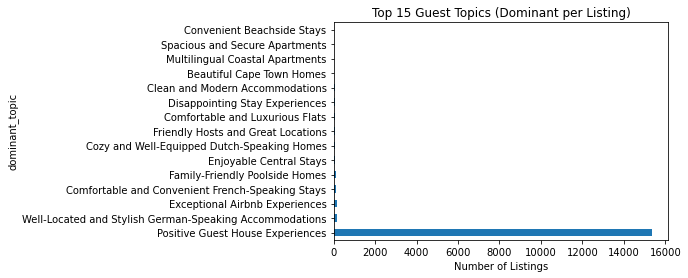

In [20]:
NLP_final['dominant_topic'].value_counts().nlargest(15).plot(kind='barh')
plt.title("Top 15 Guest Topics (Dominant per Listing)")
plt.xlabel("Number of Listings")


In [22]:
NLP_filtered = NLP_final[NLP_final['dominant_topic'] != 'Positive Guest House Experiences']


Text(0.5, 0, 'Number of Listings')

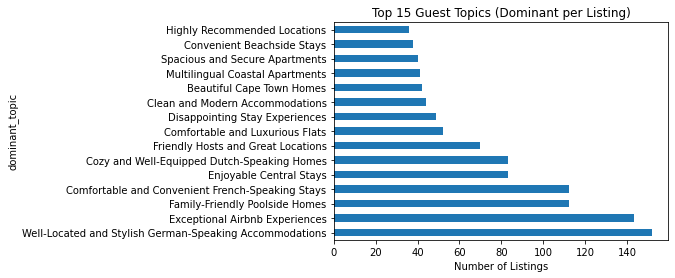

In [23]:
NLP_filtered['dominant_topic'].value_counts().nlargest(15).plot(kind='barh')
plt.title("Top 15 Guest Topics (Dominant per Listing)")
plt.xlabel("Number of Listings")


In [26]:
ct = pd.crosstab(NLP_final['dominant_topic'], NLP_final['dominant_sentiment'])
print(ct.columns)


Index(['Negative', 'Neutral', 'Positive'], dtype='object', name='dominant_sentiment')


Text(0, 0.5, 'Number of Listings')

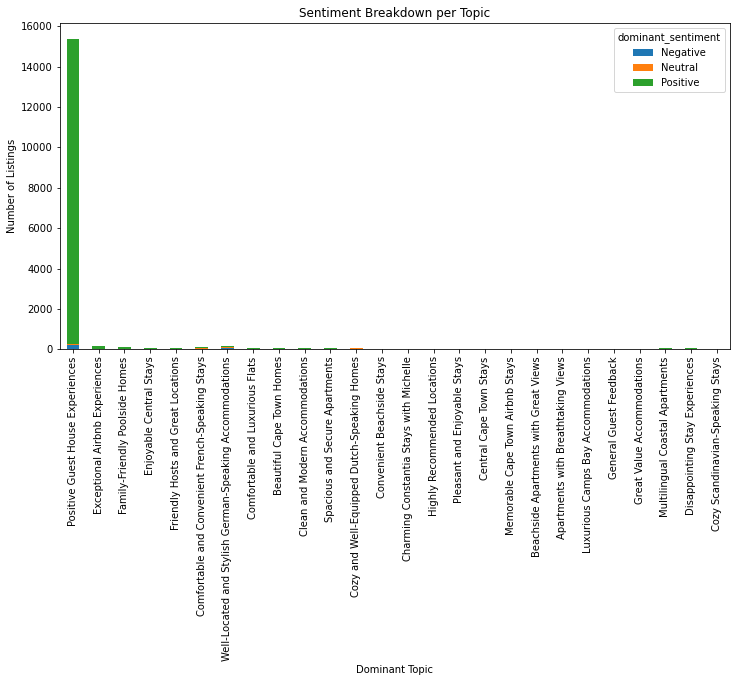

In [27]:
pd.crosstab(NLP_final['dominant_topic'], NLP_final['dominant_sentiment']) \
  .loc[lambda d: d.sum(1) > 20] \
  .sort_values('Positive', ascending=False) \
  .plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title("Sentiment Breakdown per Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Number of Listings")


Text(0, 0.5, 'Number of Listings')

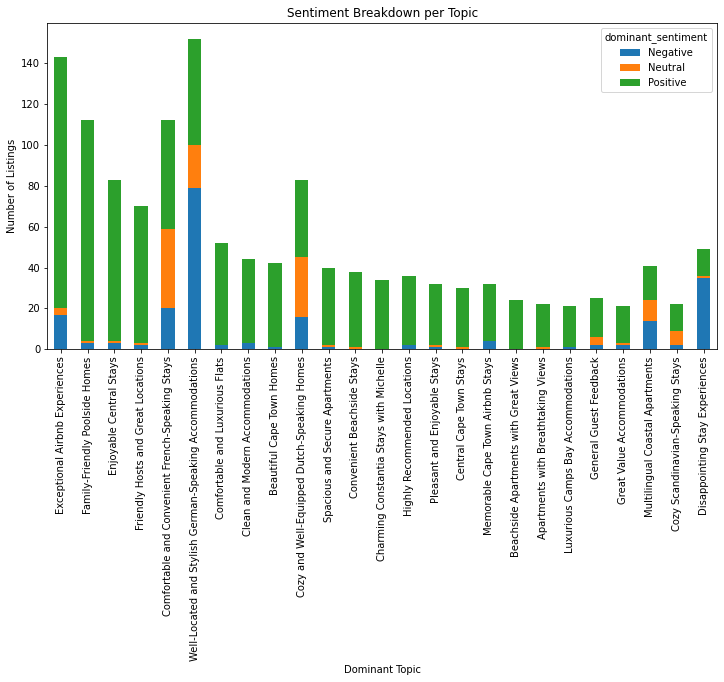

In [28]:
pd.crosstab(NLP_filtered['dominant_topic'], NLP_filtered['dominant_sentiment']) \
  .loc[lambda d: d.sum(1) > 20] \
  .sort_values('Positive', ascending=False) \
  .plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title("Sentiment Breakdown per Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Number of Listings")


Text(0.5, 1.0, 'Sentiment by Neighbourhood (Top 10)')

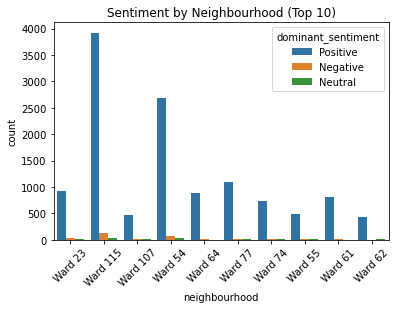

In [29]:
top_neigh = NLP_final['neighbourhood'].value_counts().nlargest(10).index
sns.countplot(data=NLP_final[NLP_final['neighbourhood'].isin(top_neigh)],
              x='neighbourhood',
              hue='dominant_sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment by Neighbourhood (Top 10)")


Text(0.5, 1.0, 'Sentiment by Neighbourhood (Top 10)')

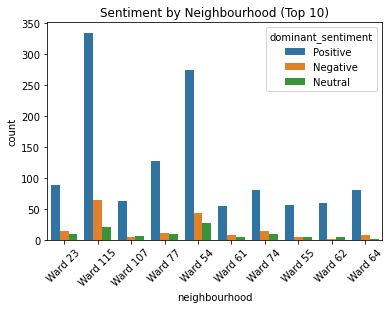

In [30]:
top_neigh = NLP_filtered['neighbourhood'].value_counts().nlargest(10).index
sns.countplot(data=NLP_filtered[NLP_filtered['neighbourhood'].isin(top_neigh)],
              x='neighbourhood',
              hue='dominant_sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment by Neighbourhood (Top 10)")


Text(0.5, 1.0, 'Sentiment Distribution by Room Type')

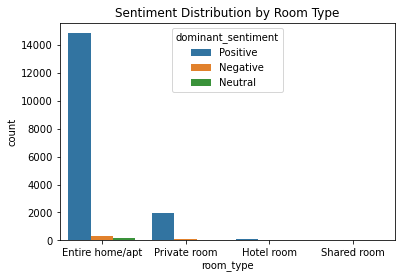

In [32]:
sns.countplot(data=NLP_final, x='room_type', hue='dominant_sentiment')
plt.title("Sentiment Distribution by Room Type")


Text(0.5, 1.0, 'Sentiment Distribution by Room Type')

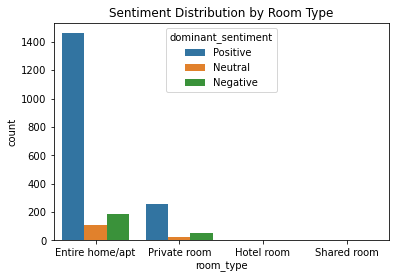

In [33]:
sns.countplot(data=NLP_filtered, x='room_type', hue='dominant_sentiment')
plt.title("Sentiment Distribution by Room Type")


Text(0.5, 1.0, 'Estimated Revenue per Sentiment Label')

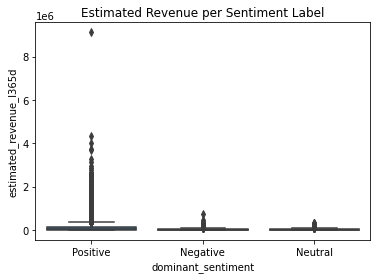

In [34]:
sns.boxplot(data=NLP_final, x='dominant_sentiment', y='estimated_revenue_l365d')
plt.title("Estimated Revenue per Sentiment Label")


Text(0.5, 1.0, 'Estimated Revenue per Sentiment Label')

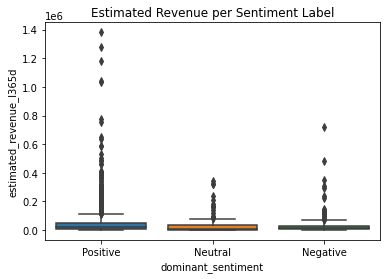

In [35]:
sns.boxplot(data=NLP_filtered, x='dominant_sentiment', y='estimated_revenue_l365d')
plt.title("Estimated Revenue per Sentiment Label")


Text(0.5, 1.0, 'Occupancy vs Guest Sentiment')

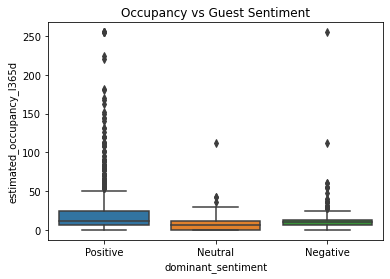

In [36]:
sns.boxplot(data=NLP_filtered, x='dominant_sentiment', y='estimated_occupancy_l365d')
plt.title("Occupancy vs Guest Sentiment")
